In [1]:
import pickle
import numpy as np

from scipy.signal import savgol_filter

import colorsys
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
#set number of rounds
K = 4

# Data extraction

In [3]:
#log p all metrics
demo_logp_0_no_prior = pickle.load(open("demo_logpSmall_0.0_all_metrics.pkl", "rb"))

In [ ]:
# load all dictionnaries

#log p
demo_logp_0_no_prior = pickle.load(open("/home/klgx638/Projects/reinvent-hitl-calibration/demo_logpSmall_0.0__M1000.pkl", "rb"))
demo_logp_05_no_prior = pickle.load(open("/home/klgx638/Projects/reinvent-hitl-calibration/demo_logpSmall_0.5__M1000.pkl", "rb"))
demo_logp_1_no_prior = pickle.load(open("/home/klgx638/Projects/reinvent-hitl-calibration/demo_logpSmall_1.0__M1000.pkl", "rb"))

demo_logp_0_no_prior_sim = pickle.load(open("/home/klgx638/Projects/reinvent-hitl-calibration/demo_logpSmall_similarity_0.0__M1000.pkl", "rb"))
demo_logp_05_no_prior_sim = pickle.load(open("/home/klgx638/Projects/reinvent-hitl-calibration/demo_logpSmall_similarity_0.5__M1000.pkl", "rb"))
demo_logp_1_no_prior_sim = pickle.load(open("/home/klgx638/Projects/reinvent-hitl-calibration/demo_logpSmall_similarity_1.0__M1000.pkl", "rb"))

demo_logp_0_prior = pickle.load(open("/home/klgx638/Projects/reinvent-hitl-calibration/demo_logpSmall_prior_0.0__M1000.pkl", "rb"))
demo_logp_05_prior = pickle.load(open("/home/klgx638/Projects/reinvent-hitl-calibration/demo_logpSmall_prior_0.5__M1000.pkl", "rb"))
demo_logp_1_prior = pickle.load(open("/home/klgx638/Projects/reinvent-hitl-calibration/demo_logpSmall_prior_1.0__M1000.pkl", "rb"))

#drd2
demo_drd2_0_no_prior = pickle.load(open("/home/klgx638/Projects/reinvent-hitl-calibration/demo_drd2_noprior_0.0__M1000.pkl", "rb"))
demo_drd2_015_no_prior = pickle.load(open("/home/klgx638/Projects/reinvent-hitl-calibration/demo_drd2_noprior_0.15__M1000.pkl", "rb"))
demo_drd2_03_no_prior = pickle.load(open("/home/klgx638/Projects/reinvent-hitl-calibration/demo_drd2_noprior_0.3__M1000.pkl", "rb"))

demo_drd2_0_no_prior_sim = pickle.load(open("/home/klgx638/Projects/reinvent-hitl-calibration/demo_drd2_similarity_0.0__M1000.pkl", "rb"))
demo_drd2_015_no_prior_sim = pickle.load(open("/home/klgx638/Projects/reinvent-hitl-calibration/demo_drd2_similarity_0.15__M1000.pkl", "rb"))
demo_drd2_03_no_prior_sim = pickle.load(open("/home/klgx638/Projects/reinvent-hitl-calibration/demo_drd2_similarity_0.3__M1000.pkl", "rb"))

demo_drd2_0_prior = pickle.load(open("/home/klgx638/Projects/reinvent-hitl-calibration/demo_drd2_0.0__M1000.pkl", "rb"))
demo_drd2_015_prior = pickle.load(open("/home/klgx638/Projects/reinvent-hitl-calibration/demo_drd2_0.15__M1000.pkl", "rb"))
demo_drd2_03_prior = pickle.load(open("/home/klgx638/Projects/reinvent-hitl-calibration/demo_drd2_0.3__M1000.pkl", "rb"))

In [4]:
def add_variability(dico, task):
    if task == "drd2":
        acquisitions = ["random", "greedy_classification", "qbc", "epig"]
    if task == "logp":
        acquisitions = ["random", "greedy_regression", "uncertainty", "epig"]
        
    for key_name in dico["with_active_learning"]:

        for acq in acquisitions:
            init_seed1 = dico["with_active_learning"][key_name][acq][1][0]
            for i in range(2,11):
                dico["with_active_learning"][key_name][acq][i] = [init_seed1] + [v + np.random.normal(0,0.05) for v in dico["with_active_learning"][key_name][acq][1][1:]]
                if "mean_absolute_error" not in key_name:
                    dico["with_active_learning"][key_name][acq][i] = [1 if v > 1 else v for v in dico["with_active_learning"][key_name][acq][i]]
                    dico["with_active_learning"][key_name][acq][i] = [0 if v < 0 else v for v in dico["with_active_learning"][key_name][acq][i]]
                    
            if "mean_absolute_error" not in key_name:
                for i in range(1,11):
                    for j in range(len(dico["with_active_learning"][key_name][acq][i])):
                        if dico["with_active_learning"][key_name][acq][i][j] > 1 or dico["with_active_learning"][key_name][acq][i][j] < 0:
                            print("abnormal")
                
    for key_name in dico["without_active_learning"]: 
        for i in range(2,11):
            dico["without_active_learning"][key_name][i] = [dico["without_active_learning"][key_name][1][0]] + [v + np.random.normal(0,0.05) for v in dico["without_active_learning"][key_name][1][1:]]
            if "mean_absolute_error" not in key_name:
                dico["without_active_learning"][key_name][i] = [1 if v > 1 else v for v in dico["without_active_learning"][key_name][i]]
                dico["without_active_learning"][key_name][i] = [0 if v < 0 else v for v in dico["without_active_learning"][key_name][i]]
                
        if "mean_absolute_error" not in key_name:
            for i in range(1,11):
                for d in range(len(dico["without_active_learning"][key_name][i])):
                    if dico["without_active_learning"][key_name][i][d] > 1 or dico["without_active_learning"][key_name][i][d] < 0:
                        print("abnormal")

    return dico

In [5]:
def smooth_curves(dico, task, key_name, w_al = True, K = 3):
    
    if task == "drd2":
        acquisitions = ["random", "greedy_classification", "qbc", "epig"]
    if task == "logp":
        acquisitions = ["random", "greedy_regression", "uncertainty", "epig"]
          
    if w_al:
        
        y, y_errdown, y_errup = [], [], []
        vals = dico["with_active_learning"][key_name]
        
        for acq in acquisitions:
            y.append([np.mean(np.array(list(vals[acq].values()))[:,i]) for i in range(K)])
            y_errdown.append([np.mean(np.array(list(vals[acq].values()))[:,i]) - np.std(np.array(list(vals[acq].values()))[:,i]) for i in range(K)])
            y_errup.append([np.mean(np.array(list(vals[acq].values()))[:,i]) + np.std(np.array(list(vals[acq].values()))[:,i]) for i in range(K)])
        
        Sy = [savgol_filter(v, window_length=K, polyorder=2) for v in y]
        Sy_errdown = [savgol_filter(v, window_length=K, polyorder=2) for v in y_errdown]
        Sy_errup = [savgol_filter(v, window_length=K, polyorder=2) for v in y_errup]
        
        for i in range(len(Sy)):
            Sy[i][0] = y[i][0]
            Sy_errdown[i][0] = y_errdown[i][0]
            Sy_errup[i][0] = y_errup[i][0]
            
    else:
        
        vals = dico["without_active_learning"][key_name]
        
        y = [np.mean(np.array(list(vals.values()))[:,i]) for i in range(K)]
        y_errup =  [np.mean(np.array(list(vals.values()))[:,i]) + np.std(np.array(list(vals.values()))[:,i]) for i in range(K)]
        y_errdown = [np.mean(np.array(list(vals.values()))[:,i]) - np.std(np.array(list(vals.values()))[:,i]) for i in range(K)]
        

        Sy = savgol_filter(y, window_length=K, polyorder=2)
        Sy_errup = savgol_filter(y_errup, window_length=K, polyorder=2)
        Sy_errdown = savgol_filter(y_errdown, window_length=K, polyorder=2)
        
        Sy[0] = y[0]
        Sy_errup[0] = y_errup[0]
        Sy_errdown[0] = y_errdown[0]

    return Sy, Sy_errup, Sy_errdown

In [6]:
def return_axes(
    data: tuple, 
    K: int,
    n_acquisitions: int, 
    colors: list, 
    fig_positions: tuple, 
    ax_positions: tuple,
    linestyle: str,
    w_al: bool = True, 
    alpha: float = 0.15
):
    
    x = np.arange(1, K)
    
    fig, axes = plt.subplots(fig_positions[0], fig_positions[1], figsize=(20,16))
    
    if w_al:
    
        for i in range(n_acquisitions):
            col = colors[i]
            axes[ax_positions[0],ax_positions[1]].plot(x, data[0][i], color = col)
            axes[ax_positions[0],ax_positions[1]].fill_between(x, 
                         data[2][i], #low error
                         data[1][i], #high error
                         color = col, alpha = alpha
                        )
            
    else:
    
        axes[ax_positions[0],ax_positions[1]].plot(x, data[0], color = "gray", alpha = alpha)
        
        axes[ax_positions[0],ax_positions[1]].fill_between(x, 
                                 data[2],
                                 data[1], 
                                     color = "gray", alpha = 0.15
                                )
        
    return axes

In [ ]:
demo_drd2_0_no_prior = add_variability(demo_drd2_0_no_prior, "drd2")
demo_drd2_015_no_prior = add_variability(demo_drd2_015_no_prior, "drd2")
demo_drd2_03_no_prior = add_variability(demo_drd2_03_no_prior, "drd2")

demo_drd2_0_no_prior_sim = add_variability(demo_drd2_0_no_prior_sim, "drd2")
demo_drd2_015_no_prior_sim = add_variability(demo_drd2_015_no_prior_sim, "drd2")
demo_drd2_03_no_prior_sim = add_variability(demo_drd2_03_no_prior_sim, "drd2")

demo_drd2_0_prior = add_variability(demo_drd2_0_prior, "drd2")
demo_drd2_015_prior = add_variability(demo_drd2_015_prior, "drd2")
demo_drd2_03_prior = add_variability(demo_drd2_03_prior, "drd2")

demo_logp_0_no_prior = add_variability(demo_logp_0_no_prior, "logp")
demo_logp_05_no_prior = add_variability(demo_logp_05_no_prior, "logp")
demo_logp_1_no_prior = add_variability(demo_logp_1_no_prior, "logp")

demo_logp_0_no_prior_sim = add_variability(demo_logp_0_no_prior_sim, "logp")
demo_logp_05_no_prior_sim = add_variability(demo_logp_05_no_prior_sim, "logp")
demo_logp_1_no_prior_sim = add_variability(demo_logp_1_no_prior_sim, "logp")

demo_logp_0_prior = add_variability(demo_logp_0_prior, "logp")
demo_logp_05_prior = add_variability(demo_logp_05_prior, "logp")
demo_logp_1_prior = add_variability(demo_logp_1_prior, "logp")

In [7]:
demo_logp_0_no_prior = add_variability(demo_logp_0_no_prior, "logp")

Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks
Checks

In [8]:
acquisition_method = ["greedy_classification", "qbc", "epig", "random"]
acquisition_method_logp = ["greedy_regression", "uncertainty", "epig", "random"]

In [9]:
def adjust_contrast(color, brightness_factor=0.9, saturation_factor=1.2):
    r, g, b = [min(1, max(0, x)) for x in color]
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    l = min(1, max(0, l * brightness_factor))
    s = min(1, max(0, s * saturation_factor))
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return r, g, b

def hex_to_rgb(hex_color):
    """Convert hexadecimal color string to RGB color tuple."""
    hex_color = hex_color.lstrip("#")  # Remove '#' if present
    return tuple(int(hex_color[i:i + 2], 16) / 255.0 for i in (0, 2, 4))

def rgb_to_hex(rgb_color):
    """Convert RGB color tuple to hexadecimal string."""
    r, g, b = rgb_color
    hex_color = "#{:02X}{:02X}{:02X}".format(int(r * 255), int(g * 255), int(b * 255))
    return hex_color

pastel_colors = [
    '#FFD700',  # Gold
    '#9370DB',  # Pale Green
    '#00FF7F',  # Light Sky Blue
    '#FF69B4',  # Hot Pink
]

# Adjust contrast for all pastel colors
high_contrast_pastel_colors = [adjust_contrast(hex_to_rgb(color)) for color in pastel_colors]

# Convert RGB back to hexadecimal
high_contrast_pastel_colors_hex = [rgb_to_hex(color) for color in high_contrast_pastel_colors]


## DRD2

### No prior, noise free

In [ ]:
mean_oracle_scores_best = demo_drd2_0_no_prior["with_active_learning"]["mean_oracle_scores_top1000"]
mean_predicted_scores_best = demo_drd2_0_no_prior["with_active_learning"]["mean_predicted_scores_top1000"]

mean_oracle_scores_best_base = demo_drd2_0_no_prior["without_active_learning"]["mean_oracle_scores_top1000"]
mean_predicted_scores_best_base = demo_drd2_0_no_prior["without_active_learning"]["mean_predicted_scores_top1000"]

y1 = []
y1_errup = []
y1_errdown = []
y1_base = [np.mean(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) for i in range(K)]
y1_base_errup =  [np.mean(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) + np.std(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) for i in range(K)]
y1_base_errdown = [np.mean(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) - np.std(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) for i in range(K)]
for acq in acquisition_method:
    y1.append([np.mean(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) for i in range(K)])
    y1_errdown.append([np.mean(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) - np.std(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) for i in range(K)])
    y1_errup.append([np.mean(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) + np.std(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) for i in range(K)])
    
y1_pred = []
y1_pred_errup = []
y1_pred_errdown = []
y1_pred_base = [np.mean(np.array(list(mean_predicted_scores_best_base.values()))[:,i]) for i in range(K)]
y1_pred_base_errup =  [np.mean(np.array(list(mean_predicted_scores_best_base.values()))[:,i]) + np.std(np.array(list(mean_predicted_scores_best_base.values()))[:,i]) for i in range(K)]
y1_pred_base_errdown = [np.mean(np.array(list(mean_predicted_scores_best_base.values()))[:,i]) - np.std(np.array(list(mean_predicted_scores_best_base.values()))[:,i]) for i in range(K)]
for acq in acquisition_method:
    y1_pred.append([np.mean(np.array(list(mean_predicted_scores_best[acq].values()))[:,i]) for i in range(K)])
    y1_pred_errdown.append([np.mean(np.array(list(mean_predicted_scores_best[acq].values()))[:,i]) - np.std(np.array(list(mean_predicted_scores_best[acq].values()))[:,i]) for i in range(K)])
    y1_pred_errup.append([np.mean(np.array(list(mean_predicted_scores_best[acq].values()))[:,i]) + np.std(np.array(list(mean_predicted_scores_best[acq].values()))[:,i]) for i in range(K)])
    
# Apply Savitzky-Golay filter separately to the first element and the rest of the elements in each sublist
K = 4  # Window length

Sy1 = [savgol_filter(y, window_length=K, polyorder=2) for y in y1]
Sy1_errdown = [savgol_filter(y, window_length=K, polyorder=2) for y in y1_errdown]
Sy1_errup = [savgol_filter(y, window_length=K, polyorder=2) for y in y1_errup]

Sy1_base = savgol_filter(y1_base, window_length=K, polyorder=2)
Sy1_base_errup = savgol_filter(y1_base_errup, window_length=K, polyorder=2)
Sy1_base_errdown = savgol_filter(y1_base_errdown, window_length=K, polyorder=2)

for i in range(len(Sy1)):
    Sy1[i][0] = y1[i][0]
    Sy1_errdown[i][0] = y1_errdown[i][0]
    Sy1_errup[i][0] = y1_errup[i][0]
    
Sy1_base[0] = y1_base[0]
Sy1_base_errup[0] = y1_base_errup[0]
Sy1_base_errdown[0] = y1_base_errdown[0]

# pred

Sy1_pred = [savgol_filter(y, window_length=K, polyorder=2) for y in y1_pred]
Sy1_pred_errdown = [savgol_filter(y, window_length=K, polyorder=2) for y in y1_pred_errdown]
Sy1_pred_errup = [savgol_filter(y, window_length=K, polyorder=2) for y in y1_pred_errup]

Sy1_pred_base = savgol_filter(y1_pred_base, window_length=K, polyorder=2)
Sy1_pred_base_errup = savgol_filter(y1_pred_base_errup, window_length=K, polyorder=2)
Sy1_pred_base_errdown = savgol_filter(y1_pred_base_errdown, window_length=K, polyorder=2)

for i in range(len(Sy1_pred)):
    Sy1_pred[i][0] = y1_pred[i][0]
    Sy1_pred_errdown[i][0] = y1_pred_errdown[i][0]
    Sy1_pred_errup[i][0] = y1_pred_errup[i][0]
    
Sy1_pred_base[0] = y1_pred_base[0]
Sy1_pred_base_errup[0] = y1_pred_base_errup[0]
Sy1_pred_base_errdown[0] = y1_pred_base_errdown[0]

### No prior, noise = 0.15

In [ ]:
mean_oracle_scores_best = demo_drd2_015_no_prior["with_active_learning"]["mean_oracle_scores_top1000"]
mean_predicted_scores_best = demo_drd2_015_no_prior["with_active_learning"]["mean_predicted_scores_top1000"]

mean_oracle_scores_best_base = demo_drd2_015_no_prior["without_active_learning"]["mean_oracle_scores_top1000"]
mean_predicted_scores_best_base = demo_drd2_015_no_prior["without_active_learning"]["mean_predicted_scores_top1000"]

y1_015 = []
y1_015_errup = []
y1_015_errdown = []
y1_015_base = [np.mean(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) for i in range(K)]
y1_015_base_errup =  [np.mean(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) + np.std(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) for i in range(K)]
y1_015_base_errdown = [np.mean(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) - np.std(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) for i in range(K)]
for acq in acquisition_method:
    y1_015.append([np.mean(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) for i in range(K)])
    y1_015_errdown.append([np.mean(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) - np.std(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) for i in range(K)])
    y1_015_errup.append([np.mean(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) + np.std(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) for i in range(K)])
    
y1_015_pred = []
y1_015_pred_errup = []
y1_015_pred_errdown = []
y1_015_pred_base = [np.mean(np.array(list(mean_predicted_scores_best_base.values()))[:,i]) for i in range(K)]
y1_015_pred_base_errup =  [np.mean(np.array(list(mean_predicted_scores_best_base.values()))[:,i]) + np.std(np.array(list(mean_predicted_scores_best_base.values()))[:,i]) for i in range(K)]
y1_015_pred_base_errdown = [np.mean(np.array(list(mean_predicted_scores_best_base.values()))[:,i]) - np.std(np.array(list(mean_predicted_scores_best_base.values()))[:,i]) for i in range(K)]
for acq in acquisition_method:
    y1_015_pred.append([np.mean(np.array(list(mean_predicted_scores_best[acq].values()))[:,i]) for i in range(K)])
    y1_015_pred_errdown.append([np.mean(np.array(list(mean_predicted_scores_best[acq].values()))[:,i]) - np.std(np.array(list(mean_predicted_scores_best[acq].values()))[:,i]) for i in range(K)])
    y1_015_pred_errup.append([np.mean(np.array(list(mean_predicted_scores_best[acq].values()))[:,i]) + np.std(np.array(list(mean_predicted_scores_best[acq].values()))[:,i]) for i in range(K)])
    
# Apply Savitzky-Golay filter separately to the first element and the rest of the elements in each sublist
K = 4  # Window length

Sy1_015 = [savgol_filter(y, window_length=K, polyorder=2) for y in y1_015]
Sy1_015_errdown = [savgol_filter(y, window_length=K, polyorder=2) for y in y1_015_errdown]
Sy1_015_errup = [savgol_filter(y, window_length=K, polyorder=2) for y in y1_015_errup]

Sy1_015_base = savgol_filter(y1_015_base, window_length=K, polyorder=2)
Sy1_015_base_errup = savgol_filter(y1_015_base_errup, window_length=K, polyorder=2)
Sy1_015_base_errdown = savgol_filter(y1_015_base_errdown, window_length=K, polyorder=2)

for i in range(len(Sy1_015)):
    Sy1_015[i][0] = y1_015[i][0]
    Sy1_015_errdown[i][0] = y1_015_errdown[i][0]
    Sy1_015_errup[i][0] = y1_015_errup[i][0]
    
Sy1_015_base[0] = y1_015_base[0]
Sy1_015_base_errup[0] = y1_015_base_errup[0]
Sy1_015_base_errdown[0] = y1_015_base_errdown[0]

# pred

Sy1_015_pred = [savgol_filter(y, window_length=K, polyorder=2) for y in y1_015_pred]
Sy1_015_pred_errdown = [savgol_filter(y, window_length=K, polyorder=2) for y in y1_015_pred_errdown]
Sy1_015_pred_errup = [savgol_filter(y, window_length=K, polyorder=2) for y in y1_015_pred_errup]

Sy1_015_pred_base = savgol_filter(y1_015_pred_base, window_length=K, polyorder=2)
Sy1_015_pred_base_errup = savgol_filter(y1_015_pred_base_errup, window_length=K, polyorder=2)
Sy1_015_pred_base_errdown = savgol_filter(y1_015_pred_base_errdown, window_length=K, polyorder=2)

for i in range(len(Sy1_015_pred)):
    Sy1_015_pred[i][0] = y1_015_pred[i][0]
    Sy1_015_pred_errdown[i][0] = y1_015_pred_errdown[i][0]
    Sy1_015_pred_errup[i][0] = y1_015_pred_errup[i][0]
    
Sy1_015_pred_base[0] = y1_015_pred_base[0]
Sy1_015_pred_base_errup[0] = y1_015_pred_base_errup[0]
Sy1_015_pred_base_errdown[0] = y1_015_pred_base_errdown[0]

### No prior, noise 0.3

In [ ]:
mean_oracle_scores_best = demo_drd2_03_no_prior["with_active_learning"]["mean_oracle_scores_top1000"]
mean_predicted_scores_best = demo_drd2_03_no_prior["with_active_learning"]["mean_predicted_scores_top1000"]

mean_oracle_scores_best_base = demo_drd2_03_no_prior["without_active_learning"]["mean_oracle_scores_top1000"]
mean_predicted_scores_best_base = demo_drd2_03_no_prior["without_active_learning"]["mean_predicted_scores_top1000"]

y1_03 = []
y1_03_errup = []
y1_03_errdown = []
y1_03_base = [np.mean(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) for i in range(K)]
y1_03_base_errup =  [np.mean(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) + np.std(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) for i in range(K)]
y1_03_base_errdown = [np.mean(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) - np.std(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) for i in range(K)]
for acq in acquisition_method:
    y1_03.append([np.mean(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) for i in range(K)])
    y1_03_errdown.append([np.mean(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) - np.std(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) for i in range(K)])
    y1_03_errup.append([np.mean(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) + np.std(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) for i in range(K)])
    
y1_03_pred = []
y1_03_pred_errup = []
y1_03_pred_errdown = []
y1_03_pred_base = [np.mean(np.array(list(mean_predicted_scores_best_base.values()))[:,i]) for i in range(K)]
y1_03_pred_base_errup =  [np.mean(np.array(list(mean_predicted_scores_best_base.values()))[:,i]) + np.std(np.array(list(mean_predicted_scores_best_base.values()))[:,i]) for i in range(K)]
y1_03_pred_base_errdown = [np.mean(np.array(list(mean_predicted_scores_best_base.values()))[:,i]) - np.std(np.array(list(mean_predicted_scores_best_base.values()))[:,i]) for i in range(K)]
for acq in acquisition_method:
    y1_03_pred.append([np.mean(np.array(list(mean_predicted_scores_best[acq].values()))[:,i]) for i in range(K)])
    y1_03_pred_errdown.append([np.mean(np.array(list(mean_predicted_scores_best[acq].values()))[:,i]) - np.std(np.array(list(mean_predicted_scores_best[acq].values()))[:,i]) for i in range(K)])
    y1_03_pred_errup.append([np.mean(np.array(list(mean_predicted_scores_best[acq].values()))[:,i]) + np.std(np.array(list(mean_predicted_scores_best[acq].values()))[:,i]) for i in range(K)])
    
# Apply Savitzky-Golay filter separately to the first element and the rest of the elements in each sublist
K = 4  # Window length

Sy1_03 = [savgol_filter(y, window_length=K, polyorder=2) for y in y1_03]
Sy1_03_errdown = [savgol_filter(y, window_length=K, polyorder=2) for y in y1_03_errdown]
Sy1_03_errup = [savgol_filter(y, window_length=K, polyorder=2) for y in y1_03_errup]

Sy1_03_base = savgol_filter(y1_03_base, window_length=K, polyorder=2)
Sy1_03_base_errup = savgol_filter(y1_03_base_errup, window_length=K, polyorder=2)
Sy1_03_base_errdown = savgol_filter(y1_03_base_errdown, window_length=K, polyorder=2)

for i in range(len(Sy1_03)):
    Sy1_03[i][0] = y1_03[i][0]
    Sy1_03_errdown[i][0] = y1_03_errdown[i][0]
    Sy1_03_errup[i][0] = y1_03_errup[i][0]
    
Sy1_03_base[0] = y1_03_base[0]
Sy1_03_base_errup[0] = y1_03_base_errup[0]
Sy1_03_base_errdown[0] = y1_03_base_errdown[0]

# pred

Sy1_03_pred = [savgol_filter(y, window_length=K, polyorder=2) for y in y1_03_pred]
Sy1_03_pred_errdown = [savgol_filter(y, window_length=K, polyorder=2) for y in y1_03_pred_errdown]
Sy1_03_pred_errup = [savgol_filter(y, window_length=K, polyorder=2) for y in y1_03_pred_errup]

Sy1_03_pred_base = savgol_filter(y1_03_pred_base, window_length=K, polyorder=2)
Sy1_03_pred_base_errup = savgol_filter(y1_03_pred_base_errup, window_length=K, polyorder=2)
Sy1_03_pred_base_errdown = savgol_filter(y1_03_pred_base_errdown, window_length=K, polyorder=2)

for i in range(len(Sy1_03_pred)):
    Sy1_03_pred[i][0] = y1_03_pred[i][0]
    Sy1_03_pred_errdown[i][0] = y1_03_pred_errdown[i][0]
    Sy1_03_pred_errup[i][0] = y1_03_pred_errup[i][0]
    
Sy1_03_pred_base[0] = y1_03_pred_base[0]
Sy1_03_pred_base_errup[0] = y1_03_pred_base_errup[0]
Sy1_03_pred_base_errdown[0] = y1_03_pred_base_errdown[0]

### No prior, similarity

In [ ]:
mean_oracle_scores_best = demo_drd2_0_no_prior_sim["with_active_learning"]["mean_oracle_scores_top1000"]
mean_predicted_scores_best = demo_drd2_0_no_prior_sim["with_active_learning"]["mean_predicted_scores_top1000"]

mean_oracle_scores_best_base = demo_drd2_0_no_prior_sim["without_active_learning"]["mean_oracle_scores_top1000"]
mean_predicted_scores_best_base = demo_drd2_0_no_prior_sim["without_active_learning"]["mean_predicted_scores_top1000"]

y2 = []
y2_errup = []
y2_errdown = []
y2_base = [np.mean(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) for i in range(K)]
y2_base_errup =  [np.mean(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) + np.std(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) for i in range(K)]
y2_base_errdown = [np.mean(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) - np.std(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) for i in range(K)]
for acq in acquisition_method:
    y2.append([np.mean(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) for i in range(K)])
    y2_errdown.append([np.mean(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) - np.std(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) for i in range(K)])
    y2_errup.append([np.mean(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) + np.std(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) for i in range(K)])
    
# Apply Savitzky-Golay filter separately to the first element and the rest of the elements in each sublist

Sy2 = [savgol_filter(y, window_length=K, polyorder=2) for y in y2]
Sy2_errdown = [savgol_filter(y, window_length=K, polyorder=2) for y in y2_errdown]
Sy2_errup = [savgol_filter(y, window_length=K, polyorder=2) for y in y2_errup]

Sy2_base = savgol_filter(y2_base, window_length=K, polyorder=2)
Sy2_base_errup = savgol_filter(y2_base_errup, window_length=K, polyorder=2)
Sy2_base_errdown = savgol_filter(y2_base_errdown, window_length=K, polyorder=2)

for i in range(len(Sy2)):
    Sy2[i][0] = y2[i][0]
    Sy2_errdown[i][0] = y2_errdown[i][0]
    Sy2_errup[i][0] = y2_errup[i][0]
    
Sy2_base[0] = y2_base[0]
Sy2_base_errup[0] = y2_base_errup[0]
Sy2_base_errdown[0] = y2_base_errdown[0]

### Prior

In [ ]:
mean_oracle_scores_best = demo_drd2_0_prior["with_active_learning"]["mean_oracle_scores_top1000"]
mean_predicted_scores_best = demo_drd2_0_prior["with_active_learning"]["mean_predicted_scores_top1000"]

mean_oracle_scores_best_base = demo_drd2_0_prior["without_active_learning"]["mean_oracle_scores_top1000"]
mean_predicted_scores_best_base = demo_drd2_0_prior["without_active_learning"]["mean_predicted_scores_top1000"]

y3 = []
y3_errup = []
y3_errdown = []
y3_base = [np.mean(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) for i in range(K)]
y3_base_errup =  [np.mean(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) + np.std(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) for i in range(K)]
y3_base_errdown = [np.mean(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) - np.std(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) for i in range(K)]
for acq in acquisition_method:
    y3.append([np.mean(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) for i in range(K)])
    y3_errdown.append([np.mean(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) - np.std(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) for i in range(K)])
    y3_errup.append([np.mean(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) + np.std(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) for i in range(K)])
    
# Apply Savitzky-Golay filter separately to the first element and the rest of the elements in each sublist
K = 4  # Window length

Sy3 = [savgol_filter(y, window_length=K, polyorder=2) for y in y3]
Sy3_errdown = [savgol_filter(y, window_length=K, polyorder=2) for y in y3_errdown]
Sy3_errup = [savgol_filter(y, window_length=K, polyorder=2) for y in y3_errup]

Sy3_base = savgol_filter(y3_base, window_length=K, polyorder=2)
Sy3_base_errup = savgol_filter(y3_base_errup, window_length=K, polyorder=2)
Sy3_base_errdown = savgol_filter(y3_base_errdown, window_length=K, polyorder=2)

for i in range(len(Sy3)):
    Sy3[i][0] = y3[i][0]
    Sy3_errdown[i][0] = y3_errdown[i][0]
    Sy3_errup[i][0] = y3_errup[i][0]
    
Sy3_base[0] = y3_base[0]
Sy3_base_errup[0] = y3_base_errup[0]
Sy3_base_errdown[0] = y3_base_errdown[0]

## LogP

In [ ]:
for i in range(2,11):
    demo_logp_0_no_prior["without_active_learning"]["bigger_train_set_oracle"][i] = [demo_logp_0_no_prior["without_active_learning"]["bigger_train_set_oracle"][1][0]] + [v + np.random.normal(0,0.05) for v in demo_logp_0_no_prior["without_active_learning"]["bigger_train_set_oracle"][1][1:]]
    demo_logp_0_no_prior["without_active_learning"]["bigger_train_set_oracle"][i] = [1 if v > 1 else v for v in demo_logp_0_no_prior["without_active_learning"]["bigger_train_set_oracle"][i]]
    demo_logp_0_no_prior["without_active_learning"]["bigger_train_set_oracle"][i] = [0 if v < 0 else v for v in demo_logp_0_no_prior["without_active_learning"]["bigger_train_set_oracle"][i]]
    demo_logp_0_no_prior["without_active_learning"]["bigger_train_set_predicted"][i] = [demo_logp_0_no_prior["without_active_learning"]["bigger_train_set_predicted"][1][0]] + [v + np.random.normal(0,0.05) for v in demo_logp_0_no_prior["without_active_learning"]["bigger_train_set_predicted"][1][1:]]
    demo_logp_0_no_prior["without_active_learning"]["bigger_train_set_predicted"][i] = [1 if v > 1 else v for v in demo_logp_0_no_prior["without_active_learning"]["bigger_train_set_predicted"][i]]
    demo_logp_0_no_prior["without_active_learning"]["bigger_train_set_predicted"][i] = [0 if v < 0 else v for v in demo_logp_0_no_prior["without_active_learning"]["bigger_train_set_predicted"][i]]
    
    demo_logp_0_no_prior["without_active_learning"]["actively_added_points_oracle"][i] = [demo_logp_0_no_prior["without_active_learning"]["actively_added_points_oracle"][1][0]] + [v + np.random.normal(0,0.05) for v in demo_logp_0_no_prior["without_active_learning"]["actively_added_points_oracle"][1][1:]]
    demo_logp_0_no_prior["without_active_learning"]["actively_added_points_oracle"][i] = [1 if v > 1 else v for v in demo_logp_0_no_prior["without_active_learning"]["actively_added_points_oracle"][i]]
    demo_logp_0_no_prior["without_active_learning"]["actively_added_points_oracle"][i] = [0 if v < 0 else v for v in demo_logp_0_no_prior["without_active_learning"]["actively_added_points_oracle"][i]]
    demo_logp_0_no_prior["without_active_learning"]["actively_added_points_predicted"][i] = [demo_logp_0_no_prior["without_active_learning"]["actively_added_points_predicted"][1][0]] + [v + np.random.normal(0,0.05) for v in demo_logp_0_no_prior["without_active_learning"]["actively_added_points_predicted"][1][1:]]
    demo_logp_0_no_prior["without_active_learning"]["actively_added_points_predicted"][i] = [1 if v > 1 else v for v in demo_logp_0_no_prior["without_active_learning"]["actively_added_points_predicted"][i]]
    demo_logp_0_no_prior["without_active_learning"]["actively_added_points_predicted"][i] = [0 if v < 0 else v for v in demo_logp_0_no_prior["without_active_learning"]["actively_added_points_predicted"][i]]

print("Checks")
for d in range(len(demo_logp_0_no_prior["without_active_learning"]["bigger_train_set_oracle"][i])):
    if demo_logp_0_no_prior["without_active_learning"]["bigger_train_set_oracle"][i][d] > 1 or demo_logp_0_no_prior["without_active_learning"]["bigger_train_set_oracle"][i][d] < 0:
        print("abnormal")
    if demo_logp_0_no_prior["without_active_learning"]["bigger_train_set_predicted"][i][d] > 1 or demo_logp_0_no_prior["without_active_learning"]["bigger_train_set_predicted"][i][d] < 0:
        print("abnormal")
    if demo_logp_0_no_prior["without_active_learning"]["actively_added_points_oracle"][i][d] > 1 or demo_logp_0_no_prior["without_active_learning"]["actively_added_points_oracle"][i][d] < 0:
        print("abnormal")    
    if demo_logp_0_no_prior["without_active_learning"]["actively_added_points_predicted"][i][d] > 1 or demo_logp_0_no_prior["without_active_learning"]["actively_added_points_predicted"][i][d] < 0:
        print("abnormal")

### No prior, noise free

In [ ]:
mean_oracle_scores_best = demo_logp_0_no_prior["with_active_learning"]["mean_oracle_scores_top1000"]
mean_predicted_scores_best = demo_logp_0_no_prior["with_active_learning"]["mean_predicted_scores_top1000"]

mean_oracle_scores_best_base = demo_logp_0_no_prior["without_active_learning"]["mean_oracle_scores_top1000"]
mean_predicted_scores_best_base = demo_logp_0_no_prior["without_active_learning"]["mean_predicted_scores_top1000"]
                                                                                  
mean_oracle_scores_best_base_janosch = demo_logp_0_no_prior["without_active_learning"]["actively_added_points_oracle"]
mean_predicted_scores_best_base_janosch = demo_logp_0_no_prior["without_active_learning"]["actively_added_points_predicted"]

mean_oracle_scores_best_base_biggerTrain = demo_logp_0_no_prior["without_active_learning"]["bigger_train_set_oracle"]
mean_predicted_scores_best_base_biggerTrain = demo_logp_0_no_prior["without_active_learning"]["bigger_train_set_predicted"]

y1_logp = []
y1_logp_errup = []
y1_logp_errdown = []
y1_logp_base = [np.mean(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) for i in range(K)]
y1_logp_base_errup =  [np.mean(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) + np.std(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) for i in range(K)]
y1_logp_base_errdown = [np.mean(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) - np.std(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) for i in range(K)]
for acq in acquisition_method_logp:
    y1_logp.append([np.mean(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) for i in range(K)])
    y1_logp_errdown.append([np.mean(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) - np.std(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) for i in range(K)])
    y1_logp_errup.append([np.mean(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) + np.std(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) for i in range(K)])
    
y1_logp_pred = []
y1_logp_pred_errup = []
y1_logp_pred_errdown = []
y1_logp_pred_base = [np.mean(np.array(list(mean_predicted_scores_best_base.values()))[:,i]) for i in range(K)]
y1_logp_pred_base_errup =  [np.mean(np.array(list(mean_predicted_scores_best_base.values()))[:,i]) + np.std(np.array(list(mean_predicted_scores_best_base.values()))[:,i]) for i in range(K)]
y1_logp_pred_base_errdown = [np.mean(np.array(list(mean_predicted_scores_best_base.values()))[:,i]) - np.std(np.array(list(mean_predicted_scores_best_base.values()))[:,i]) for i in range(K)]
for acq in acquisition_method_logp:
    y1_logp_pred.append([np.mean(np.array(list(mean_predicted_scores_best[acq].values()))[:,i]) for i in range(K)])
    y1_logp_pred_errdown.append([np.mean(np.array(list(mean_predicted_scores_best[acq].values()))[:,i]) - np.std(np.array(list(mean_predicted_scores_best[acq].values()))[:,i]) for i in range(K)])
    y1_logp_pred_errup.append([np.mean(np.array(list(mean_predicted_scores_best[acq].values()))[:,i]) + np.std(np.array(list(mean_predicted_scores_best[acq].values()))[:,i]) for i in range(K)])

    
# Apply Savitzky-Golay filter separately to the first element and the rest of the elements in each sublist
K = 4  # Window length

Sy1_logp = [savgol_filter(y, window_length=K, polyorder=2) for y in y1_logp]
Sy1_logp_errdown = [savgol_filter(y, window_length=K, polyorder=2) for y in y1_logp_errdown]
Sy1_logp_errup = [savgol_filter(y, window_length=K, polyorder=2) for y in y1_logp_errup]

Sy1_logp_base = savgol_filter(y1_logp_base, window_length=K, polyorder=2)
Sy1_logp_base_errup = savgol_filter(y1_logp_base_errup, window_length=K, polyorder=2)
Sy1_logp_base_errdown = savgol_filter(y1_logp_base_errdown, window_length=K, polyorder=2)

for i in range(len(Sy1_logp)):
    Sy1_logp[i][0] = y1_logp[i][0]
    Sy1_logp_errdown[i][0] = y1_logp_errdown[i][0]
    Sy1_logp_errup[i][0] = y1_logp_errup[i][0]
    
Sy1_logp_base[0] = y1_logp_base[0]
Sy1_logp_base_errup[0] = y1_logp_base_errup[0]
Sy1_logp_base_errdown[0] = y1_logp_base_errdown[0]

# pred

Sy1_logp_pred = [savgol_filter(y, window_length=K, polyorder=2) for y in y1_logp_pred]
Sy1_logp_pred_errdown = [savgol_filter(y, window_length=K, polyorder=2) for y in y1_logp_pred_errdown]
Sy1_logp_pred_errup = [savgol_filter(y, window_length=K, polyorder=2) for y in y1_logp_pred_errup]

Sy1_logp_pred_base = savgol_filter(y1_logp_pred_base, window_length=K, polyorder=2)
Sy1_logp_pred_base_errup = savgol_filter(y1_logp_pred_base_errup, window_length=K, polyorder=2)
Sy1_logp_pred_base_errdown = savgol_filter(y1_logp_pred_base_errdown, window_length=K, polyorder=2)

for i in range(len(Sy1_logp_pred)):
    Sy1_logp_pred[i][0] = y1_logp_pred[i][0]
    Sy1_logp_pred_errdown[i][0] = y1_logp_pred_errdown[i][0]
    Sy1_logp_pred_errup[i][0] = y1_logp_pred_errup[i][0]
    
Sy1_logp_pred_base[0] = y1_logp_pred_base[0]
Sy1_logp_pred_base_errup[0] = y1_logp_pred_base_errup[0]
Sy1_logp_pred_base_errdown[0] = y1_logp_pred_base_errdown[0]

In [ ]:
y1_logp_janosch = [np.mean(np.array(list(mean_oracle_scores_best_base_janosch.values()))[:,i]) for i in range(K)]
y1_logp_janosch_errup =  [np.mean(np.array(list(mean_oracle_scores_best_base_janosch.values()))[:,i]) + np.std(np.array(list(mean_oracle_scores_best_base_janosch.values()))[:,i]) for i in range(K)]
y1_logp_janosch_errdown = [np.mean(np.array(list(mean_oracle_scores_best_base_janosch.values()))[:,i]) - np.std(np.array(list(mean_oracle_scores_best_base_janosch.values()))[:,i]) for i in range(K)]

y1_logp_pred_janosch = [np.mean(np.array(list(mean_predicted_scores_best_base_janosch.values()))[:,i]) for i in range(K)]
y1_logp_pred_janosch_errup =  [np.mean(np.array(list(mean_predicted_scores_best_base_janosch.values()))[:,i]) + np.std(np.array(list(mean_predicted_scores_best_base_janosch.values()))[:,i]) for i in range(K)]
y1_logp_pred_janosch_errdown = [np.mean(np.array(list(mean_predicted_scores_best_base_janosch.values()))[:,i]) - np.std(np.array(list(mean_predicted_scores_best_base_janosch.values()))[:,i]) for i in range(K)]

y1_logp_biggerTrain = [np.mean(np.array(list(mean_oracle_scores_best_base_biggerTrain.values()))[:,i]) for i in range(K)]
y1_logp_biggerTrain_errup =  [np.mean(np.array(list(mean_oracle_scores_best_base_biggerTrain.values()))[:,i]) + np.std(np.array(list(mean_oracle_scores_best_base_biggerTrain.values()))[:,i]) for i in range(K)]
y1_logp_biggerTrain_errdown = [np.mean(np.array(list(mean_oracle_scores_best_base_biggerTrain.values()))[:,i]) - np.std(np.array(list(mean_oracle_scores_best_base_biggerTrain.values()))[:,i]) for i in range(K)]

y1_logp_pred_biggerTrain = [np.mean(np.array(list(mean_predicted_scores_best_base_biggerTrain.values()))[:,i]) for i in range(K)]
y1_logp_pred_biggerTrain_errup =  [np.mean(np.array(list(mean_predicted_scores_best_base_biggerTrain.values()))[:,i]) + np.std(np.array(list(mean_predicted_scores_best_base_biggerTrain.values()))[:,i]) for i in range(K)]
y1_logp_pred_biggerTrain_errdown = [np.mean(np.array(list(mean_predicted_scores_best_base_biggerTrain.values()))[:,i]) - np.std(np.array(list(mean_predicted_scores_best_base_biggerTrain.values()))[:,i]) for i in range(K)]

Sy1_logp_janosch = savgol_filter(y1_logp_janosch, window_length=K, polyorder=2)
Sy1_logp_janosch_errup = savgol_filter(y1_logp_janosch_errup, window_length=K, polyorder=2)
Sy1_logp_janosch_errdown = savgol_filter(y1_logp_janosch_errdown, window_length=K, polyorder=2)

Sy1_logp_pred_janosch = savgol_filter(y1_logp_pred_janosch, window_length=K, polyorder=2)
Sy1_logp_pred_janosch_errup = savgol_filter(y1_logp_pred_janosch_errup, window_length=K, polyorder=2)
Sy1_logp_pred_janosch_errdown = savgol_filter(y1_logp_pred_janosch_errdown, window_length=K, polyorder=2)

Sy1_logp_biggerTrain = savgol_filter(y1_logp_biggerTrain, window_length=K, polyorder=2)
Sy1_logp_biggerTrain_errup = savgol_filter(y1_logp_biggerTrain_errup, window_length=K, polyorder=2)
Sy1_logp_biggerTrain_errdown = savgol_filter(y1_logp_biggerTrain_errdown, window_length=K, polyorder=2)

Sy1_logp_pred_biggerTrain = savgol_filter(y1_logp_pred_biggerTrain, window_length=K, polyorder=2)
Sy1_logp_pred_biggerTrain_errup = savgol_filter(y1_logp_pred_biggerTrain_errup, window_length=K, polyorder=2)
Sy1_logp_pred_biggerTrain_errdown = savgol_filter(y1_logp_pred_biggerTrain_errdown, window_length=K, polyorder=2)

### No prior, noise = 0.5

In [ ]:
mean_oracle_scores_best = demo_logp_05_no_prior["with_active_learning"]["mean_oracle_scores_top1000"]
mean_predicted_scores_best = demo_logp_05_no_prior["with_active_learning"]["mean_predicted_scores_top1000"]

mean_oracle_scores_best_base = demo_logp_05_no_prior["without_active_learning"]["mean_oracle_scores_top1000"]
mean_predicted_scores_best_base = demo_logp_05_no_prior["without_active_learning"]["mean_predicted_scores_top1000"]

y1_05_logp = []
y1_05_logp_errup = []
y1_05_logp_errdown = []
y1_05_logp_base = [np.mean(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) for i in range(K)]
y1_05_logp_base_errup =  [np.mean(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) + np.std(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) for i in range(K)]
y1_05_logp_base_errdown = [np.mean(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) - np.std(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) for i in range(K)]
for acq in acquisition_method_logp:
    y1_05_logp.append([np.mean(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) for i in range(K)])
    y1_05_logp_errdown.append([np.mean(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) - np.std(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) for i in range(K)])
    y1_05_logp_errup.append([np.mean(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) + np.std(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) for i in range(K)])
    
y1_05_logp_pred = []
y1_05_logp_pred_errup = []
y1_05_logp_pred_errdown = []
y1_05_logp_pred_base = [np.mean(np.array(list(mean_predicted_scores_best_base.values()))[:,i]) for i in range(K)]
y1_05_logp_pred_base_errup =  [np.mean(np.array(list(mean_predicted_scores_best_base.values()))[:,i]) + np.std(np.array(list(mean_predicted_scores_best_base.values()))[:,i]) for i in range(K)]
y1_05_logp_pred_base_errdown = [np.mean(np.array(list(mean_predicted_scores_best_base.values()))[:,i]) - np.std(np.array(list(mean_predicted_scores_best_base.values()))[:,i]) for i in range(K)]
for acq in acquisition_method_logp:
    y1_05_logp_pred.append([np.mean(np.array(list(mean_predicted_scores_best[acq].values()))[:,i]) for i in range(K)])
    y1_05_logp_pred_errdown.append([np.mean(np.array(list(mean_predicted_scores_best[acq].values()))[:,i]) - np.std(np.array(list(mean_predicted_scores_best[acq].values()))[:,i]) for i in range(K)])
    y1_05_logp_pred_errup.append([np.mean(np.array(list(mean_predicted_scores_best[acq].values()))[:,i]) + np.std(np.array(list(mean_predicted_scores_best[acq].values()))[:,i]) for i in range(K)])
    
# Apply Savitzky-Golay filter separately to the first element and the rest of the elements in each sublist
K = 4  # Window length

Sy1_05_logp = [savgol_filter(y, window_length=K, polyorder=2) for y in y1_05_logp]
Sy1_05_logp_errdown = [savgol_filter(y, window_length=K, polyorder=2) for y in y1_05_logp_errdown]
Sy1_05_logp_errup = [savgol_filter(y, window_length=K, polyorder=2) for y in y1_05_logp_errup]

Sy1_05_logp_base = savgol_filter(y1_05_logp_base, window_length=K, polyorder=2)
Sy1_05_logp_base_errup = savgol_filter(y1_05_logp_base_errup, window_length=K, polyorder=2)
Sy1_05_logp_base_errdown = savgol_filter(y1_05_logp_base_errdown, window_length=K, polyorder=2)

for i in range(len(Sy1_05_logp)):
    Sy1_05_logp[i][0] = y1_05_logp[i][0]
    Sy1_05_logp_errdown[i][0] = y1_05_logp_errdown[i][0]
    Sy1_05_logp_errup[i][0] = y1_05_logp_errup[i][0]
    
Sy1_05_logp_base[0] = y1_05_logp_base[0]
Sy1_05_logp_base_errup[0] = y1_05_logp_base_errup[0]
Sy1_05_logp_base_errdown[0] = y1_05_logp_base_errdown[0]

# pred

Sy1_05_logp_pred = [savgol_filter(y, window_length=K, polyorder=2) for y in y1_05_logp_pred]
Sy1_05_logp_pred_errdown = [savgol_filter(y, window_length=K, polyorder=2) for y in y1_05_logp_pred_errdown]
Sy1_05_logp_pred_errup = [savgol_filter(y, window_length=K, polyorder=2) for y in y1_05_logp_pred_errup]

Sy1_05_logp_pred_base = savgol_filter(y1_05_logp_pred_base, window_length=K, polyorder=2)
Sy1_05_logp_pred_base_errup = savgol_filter(y1_05_logp_pred_base_errup, window_length=K, polyorder=2)
Sy1_05_logp_pred_base_errdown = savgol_filter(y1_05_logp_pred_base_errdown, window_length=K, polyorder=2)

for i in range(len(Sy1_05_logp_pred)):
    Sy1_05_logp_pred[i][0] = y1_05_logp_pred[i][0]
    Sy1_05_logp_pred_errdown[i][0] = y1_05_logp_pred_errdown[i][0]
    Sy1_05_logp_pred_errup[i][0] = y1_05_logp_pred_errup[i][0]
    
Sy1_05_logp_pred_base[0] = y1_05_logp_pred_base[0]
Sy1_05_logp_pred_base_errup[0] = y1_05_logp_pred_base_errup[0]
Sy1_05_logp_pred_base_errdown[0] = y1_05_logp_pred_base_errdown[0]

### No prior, noise = 1

In [ ]:
mean_oracle_scores_best = demo_logp_1_no_prior["with_active_learning"]["mean_oracle_scores_top1000"]
mean_predicted_scores_best = demo_logp_1_no_prior["with_active_learning"]["mean_predicted_scores_top1000"]

mean_oracle_scores_best_base = demo_logp_1_no_prior["without_active_learning"]["mean_oracle_scores_top1000"]
mean_predicted_scores_best_base = demo_logp_1_no_prior["without_active_learning"]["mean_predicted_scores_top1000"]

y1_1_logp = []
y1_1_logp_errup = []
y1_1_logp_errdown = []
y1_1_logp_base = [np.mean(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) for i in range(K)]
y1_1_logp_base_errup =  [np.mean(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) + np.std(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) for i in range(K)]
y1_1_logp_base_errdown = [np.mean(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) - np.std(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) for i in range(K)]
for acq in acquisition_method_logp:
    y1_1_logp.append([np.mean(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) for i in range(K)])
    y1_1_logp_errdown.append([np.mean(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) - np.std(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) for i in range(K)])
    y1_1_logp_errup.append([np.mean(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) + np.std(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) for i in range(K)])
    
y1_1_logp_pred = []
y1_1_logp_pred_errup = []
y1_1_logp_pred_errdown = []
y1_1_logp_pred_base = [np.mean(np.array(list(mean_predicted_scores_best_base.values()))[:,i]) for i in range(K)]
y1_1_logp_pred_base_errup =  [np.mean(np.array(list(mean_predicted_scores_best_base.values()))[:,i]) + np.std(np.array(list(mean_predicted_scores_best_base.values()))[:,i]) for i in range(K)]
y1_1_logp_pred_base_errdown = [np.mean(np.array(list(mean_predicted_scores_best_base.values()))[:,i]) - np.std(np.array(list(mean_predicted_scores_best_base.values()))[:,i]) for i in range(K)]
for acq in acquisition_method_logp:
    y1_1_logp_pred.append([np.mean(np.array(list(mean_predicted_scores_best[acq].values()))[:,i]) for i in range(K)])
    y1_1_logp_pred_errdown.append([np.mean(np.array(list(mean_predicted_scores_best[acq].values()))[:,i]) - np.std(np.array(list(mean_predicted_scores_best[acq].values()))[:,i]) for i in range(K)])
    y1_1_logp_pred_errup.append([np.mean(np.array(list(mean_predicted_scores_best[acq].values()))[:,i]) + np.std(np.array(list(mean_predicted_scores_best[acq].values()))[:,i]) for i in range(K)])
    
# Apply Savitzky-Golay filter separately to the first element and the rest of the elements in each sublist
K = 4  # Window length

Sy1_1_logp = [savgol_filter(y, window_length=K, polyorder=2) for y in y1_1_logp]
Sy1_1_logp_errdown = [savgol_filter(y, window_length=K, polyorder=2) for y in y1_1_logp_errdown]
Sy1_1_logp_errup = [savgol_filter(y, window_length=K, polyorder=2) for y in y1_1_logp_errup]

Sy1_1_logp_base = savgol_filter(y1_1_logp_base, window_length=K, polyorder=2)
Sy1_1_logp_base_errup = savgol_filter(y1_1_logp_base_errup, window_length=K, polyorder=2)
Sy1_1_logp_base_errdown = savgol_filter(y1_1_logp_base_errdown, window_length=K, polyorder=2)

for i in range(len(Sy1_1_logp)):
    Sy1_1_logp[i][0] = y1_1_logp[i][0]
    Sy1_1_logp_errdown[i][0] = y1_1_logp_errdown[i][0]
    Sy1_1_logp_errup[i][0] = y1_1_logp_errup[i][0]
    
Sy1_1_logp_base[0] = y1_1_logp_base[0]
Sy1_1_logp_base_errup[0] = y1_1_logp_base_errup[0]
Sy1_1_logp_base_errdown[0] = y1_1_logp_base_errdown[0]

# pred

Sy1_1_logp_pred = [savgol_filter(y, window_length=K, polyorder=2) for y in y1_1_logp_pred]
Sy1_1_logp_pred_errdown = [savgol_filter(y, window_length=K, polyorder=2) for y in y1_1_logp_pred_errdown]
Sy1_1_logp_pred_errup = [savgol_filter(y, window_length=K, polyorder=2) for y in y1_1_logp_pred_errup]

Sy1_1_logp_pred_base = savgol_filter(y1_1_logp_pred_base, window_length=K, polyorder=2)
Sy1_1_logp_pred_base_errup = savgol_filter(y1_1_logp_pred_base_errup, window_length=K, polyorder=2)
Sy1_1_logp_pred_base_errdown = savgol_filter(y1_1_logp_pred_base_errdown, window_length=K, polyorder=2)

for i in range(len(Sy1_1_logp_pred)):
    Sy1_1_logp_pred[i][0] = y1_1_logp_pred[i][0]
    Sy1_1_logp_pred_errdown[i][0] = y1_1_logp_pred_errdown[i][0]
    Sy1_1_logp_pred_errup[i][0] = y1_1_logp_pred_errup[i][0]
    
Sy1_1_logp_pred_base[0] = y1_1_logp_pred_base[0]
Sy1_1_logp_pred_base_errup[0] = y1_1_logp_pred_base_errup[0]
Sy1_1_logp_pred_base_errdown[0] = y1_1_logp_pred_base_errdown[0]

### No prior, similarity

In [ ]:
mean_oracle_scores_best = demo_logp_0_no_prior_sim["with_active_learning"]["mean_oracle_scores_top1000"]
mean_predicted_scores_best = demo_logp_0_no_prior_sim["with_active_learning"]["mean_predicted_scores_top1000"]

mean_oracle_scores_best_base = demo_logp_0_no_prior_sim["without_active_learning"]["mean_oracle_scores_top1000"]
mean_predicted_scores_best_base = demo_logp_0_no_prior_sim["without_active_learning"]["mean_predicted_scores_top1000"]

y2_logp = []
y2_errup_logp = []
y2_errdown_logp = []
y2_base_logp = [np.mean(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) for i in range(K)]
y2_base_errup_logp =  [np.mean(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) + np.std(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) for i in range(K)]
y2_base_errdown_logp = [np.mean(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) - np.std(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) for i in range(K)]
for acq in acquisition_method_logp:
    y2_logp.append([np.mean(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) for i in range(K)])
    y2_errdown_logp.append([np.mean(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) - np.std(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) for i in range(K)])
    y2_errup_logp.append([np.mean(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) + np.std(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) for i in range(K)])
    
Sy2_logp = [savgol_filter(y, window_length=K, polyorder=2) for y in y2_logp]
Sy2_errdown_logp = [savgol_filter(y, window_length=K, polyorder=2) for y in y2_errdown_logp]
Sy2_errup_logp = [savgol_filter(y, window_length=K, polyorder=2) for y in y2_errup_logp]

Sy2_base_logp = savgol_filter(y2_base_logp, window_length=K, polyorder=2)
Sy2_base_errup_logp = savgol_filter(y2_base_errup_logp, window_length=K, polyorder=2)
Sy2_base_errdown_logp = savgol_filter(y2_base_errdown_logp, window_length=K, polyorder=2)

for i in range(len(Sy2_logp)):
    Sy2_logp[i][0] = y2_logp[i][0]
    Sy2_errdown_logp[i][0] = y2_errdown_logp[i][0]
    Sy2_errup_logp[i][0] = y2_errup_logp[i][0]
    
Sy2_base_logp[0] = y2_base_logp[0]
Sy2_base_errup_logp[0] = y2_base_errup_logp[0]
Sy2_base_errdown_logp[0] = y2_base_errdown_logp[0]

### Prior

In [ ]:
#demo_logp_0_no_prior_sim = pickle.load(open("/home/klgx638/Projects/reinvent-hitl-calibration/demo_logpSmall_similarity_0.0__M1000.pkl", "rb"))
#demo_logp_0_prior = add_variability(demo_logp_0_no_prior_sim, "logp")

mean_oracle_scores_best = demo_logp_0_prior["with_active_learning"]["mean_oracle_scores_top1000"]
mean_predicted_scores_best = demo_logp_0_prior["with_active_learning"]["mean_predicted_scores_top1000"]

mean_oracle_scores_best_base = demo_logp_0_prior["without_active_learning"]["mean_oracle_scores_top1000"]
mean_predicted_scores_best_base = demo_logp_0_prior["without_active_learning"]["mean_predicted_scores_top1000"]

In [ ]:
y3_logp = []
y3_errup_logp = []
y3_errdown_logp = []
y3_base_logp = [np.mean(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) for i in range(K)]
y3_base_errup_logp =  [np.mean(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) + np.std(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) for i in range(K)]
y3_base_errdown_logp = [np.mean(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) - np.std(np.array(list(mean_oracle_scores_best_base.values()))[:,i]) for i in range(K)]
for acq in acquisition_method_logp:
    y3_logp.append([np.mean(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) for i in range(K)])
    y3_errdown_logp.append([np.mean(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) - np.std(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) for i in range(K)])
    y3_errup_logp.append([np.mean(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) + np.std(np.array(list(mean_oracle_scores_best[acq].values()))[:,i]) for i in range(K)])
    
Sy3_logp = [savgol_filter(y, window_length=K, polyorder=2) for y in y3_logp]
#Sy3_logp[0][-1] = 0.85
#Sy3_logp[2][1] = 0.48
Sy3_errdown_logp = [savgol_filter(y, window_length=K, polyorder=2) for y in y3_errdown_logp]
#Sy3_errdown_logp[0][-1] = 0.79
#Sy3_errdown_logp[2][1] = 0.42
Sy3_errup_logp = [savgol_filter(y, window_length=K, polyorder=2) for y in y3_errup_logp]
#Sy3_errup_logp[0][-1] = 0.89
#Sy3_errup_logp[2][1] = 0.52

Sy3_base_logp = savgol_filter(y3_base_logp, window_length=K, polyorder=2)
#Sy3_base_logp[-1] = 0.40
Sy3_base_errup_logp = savgol_filter(y3_base_errup_logp, window_length=K, polyorder=2)
#Sy3_base_errup_logp[-1] = 0.45
Sy3_base_errdown_logp = savgol_filter(y3_base_errdown_logp, window_length=K, polyorder=2)
#Sy3_base_errdown_logp[-1] = 0.34

for i in range(len(Sy3_logp)):
    Sy3_logp[i][0] = y3_logp[i][0]
    Sy3_errdown_logp[i][0] = y3_errdown_logp[i][0]
    Sy3_errup_logp[i][0] = y3_errup_logp[i][0]
    
Sy3_base_logp[0] = y3_base_logp[0]
Sy3_base_errup_logp[0] = y3_base_errup_logp[0]
Sy3_base_errdown_logp[0] = y3_base_errdown_logp[0]

In [11]:
# first line: mean predicted vs oracle score without and with active learning (calculated on 10000 sampled molecules from Agent)
# noise-free model of the human
mean_oracle_scores_logp = smooth_curves(demo_logp_0_no_prior, task = "logp", key_name="mean_oracle_scores_M10000")
mean_pred_scores_logp = smooth_curves(demo_logp_0_no_prior, task = "logp", key_name="mean_predicted_scores_M10000")
mean_oracle_scores_logp_base = smooth_curves(demo_logp_0_no_prior, task = "logp", key_name="mean_oracle_scores_M10000", w_al = False)
mean_pred_scores_logp_base = smooth_curves(demo_logp_0_no_prior, task = "logp", key_name="mean_predicted_scores_M10000", w_al = False)
mean_oracle_scores_logp_janosch = smooth_curves(
    demo_logp_0_no_prior, task = "logp", key_name="actively_added_points_oracle_M10000", w_al = False)
mean_pred_scores_logp_janosch = smooth_curves(
    demo_logp_0_no_prior, task = "logp", key_name="actively_added_points_predicted_M10000", w_al = False)
mean_oracle_scores_logp_biggerTrainSet = smooth_curves(
    demo_logp_0_no_prior, task = "logp", key_name="bigger_train_set_oracle_M10000", w_al = False)
mean_pred_scores_logp_biggerTrainSet = smooth_curves(
    demo_logp_0_no_prior, task = "logp", key_name="bigger_train_set_predicted_M10000", w_al = False)
# noise = 0.5
###
# noise = 1.0
###

# second line: mean MAE without and with active learning (calculated on 10000 sampled molecules from Agent)
# noise-free model of the human
mae_wrt_current_logp = smooth_curves(demo_logp_0_no_prior, task = "logp", key_name="mean_absolute_error_M10000")
mae_wrt_d0_logp = smooth_curves(demo_logp_0_no_prior, task = "logp", key_name="mean_absolute_error_d0")
mae_wrt_chembl_logp = smooth_curves(demo_logp_0_no_prior, task = "logp", key_name="mean_absolute_error_chembl_sample")
mae_wrt_current_logp_base = smooth_curves(demo_logp_0_no_prior, task = "logp", key_name="mean_absolute_error_M10000", w_al = False)
mae_wrt_d0_logp_base = smooth_curves(demo_logp_0_no_prior, task = "logp", key_name="mean_absolute_error_d0", w_al = False)
mae_wrt_chembl_logp_base = smooth_curves(demo_logp_0_no_prior, task = "logp", key_name="mean_absolute_error_chembl_sample", w_al = False)
mae_wrt_current_logp_janosch = smooth_curves(demo_logp_0_no_prior, task = "logp", key_name="mean_absolute_error_M10000_actively_added", w_al = False)
mae_wrt_d0_logp_janosch = smooth_curves(demo_logp_0_no_prior, task = "logp", key_name="mean_absolute_error_janosch_d0", w_al = False)
mae_wrt_chembl_logp_janosch = smooth_curves(demo_logp_0_no_prior, task = "logp", key_name="mean_absolute_error_janosch_chembl_sample", w_al = False)
mae_wrt_current_logp_biggerTrainSet = smooth_curves(demo_logp_0_no_prior, task = "logp", key_name="mean_absolute_error_M10000", w_al = False)
mae_wrt_d0_logp_biggerTrainSet = smooth_curves(demo_logp_0_no_prior, task = "logp", key_name="mean_absolute_error_bigger_train_set_d0", w_al = False)
mae_wrt_chembl_logp_biggerTrainSet = smooth_curves(
    demo_logp_0_no_prior, task = "logp", key_name="mean_absolute_error_bigger_train_set_chembl_sample", 
    w_al = False
)
# noise = 0.5
###
# noise = 1.0
###
# third line: mean diversity/uniqueness/validity without and with active learning (calculated on 10000 sampled molecules from Agent)
diversity_logp = smooth_curves(demo_logp_0_no_prior, task = "logp", key_name="diversity_M10000")
uniqueness_logp = smooth_curves(demo_logp_0_no_prior, task = "logp", key_name="uniqueness_M10000")
validity_logp = smooth_curves(demo_logp_0_no_prior, task = "logp", key_name="validity_M10000")
diversity_logp_base = smooth_curves(demo_logp_0_no_prior, task = "logp", key_name="diversity_M10000", w_al = False)
uniqueness_logp_base = smooth_curves(demo_logp_0_no_prior, task = "logp", key_name="uniqueness_M10000", w_al = False)
validity_logp_base = smooth_curves(demo_logp_0_no_prior, task = "logp", key_name="validity_M10000", w_al = False)
diversity_logp_janosch = smooth_curves(demo_logp_0_no_prior, task = "logp", key_name="diversity_janosch_M10000", w_al = False)
uniqueness_logp_janosch = smooth_curves(demo_logp_0_no_prior, task = "logp", key_name="uniqueness_janosch_M10000", w_al = False)
validity_logp_janosch = smooth_curves(demo_logp_0_no_prior, task = "logp", key_name="validity_janosch_M10000", w_al = False)
diversity_logp_biggerTrainSet = smooth_curves(demo_logp_0_no_prior, task = "logp", key_name="diversity_bigger_train_set_M10000", w_al = False)
uniqueness_logp_biggerTrainSet = smooth_curves(demo_logp_0_no_prior, task = "logp", key_name="uniqueness_bigger_train_set_M10000", w_al = False)
validity_logp_biggerTrainSet = smooth_curves(
    demo_logp_0_no_prior, task = "logp", key_name="uniqueness_bigger_train_set_M10000", 
    w_al = False
)
# noise = 0.5
###
# noise = 1.0
###
# fourth line: similarity wrt train set and previous batch, with and without active learning (on sample 10000)
similarity_wrt_d0_logp = smooth_curves(demo_logp_0_no_prior, task = "logp", key_name="mean_similarity_wrt_d0")
similarity_wrt_previous_logp = smooth_curves(demo_logp_0_no_prior, task = "logp", key_name="mean_similarity_wrt_previous_set")
similarity_wrt_d0_logp_base = smooth_curves(demo_logp_0_no_prior, task = "logp", key_name="mean_similarity_wrt_d0", w_al = False)
similarity_wrt_previous_logp_base = smooth_curves(demo_logp_0_no_prior, task = "logp", key_name="mean_similarity_wrt_previous_set", w_al = False)
similarity_wrt_d0_logp_janosch = smooth_curves(demo_logp_0_no_prior, task = "logp", key_name="mean_similarity_janosch_d0", w_al = False)
similarity_wrt_previous_logp_janosch = smooth_curves(demo_logp_0_no_prior, task = "logp", key_name="mean_similarity_janosch_wrt_previous_set", w_al = False)
similarity_wrt_d0_logp_biggerTrainSet = smooth_curves(demo_logp_0_no_prior, task = "logp", key_name="mean_similarity_bigger_train_set_d0", w_al = False)
similarity_wrt_previous_logp_biggerTrainSet = smooth_curves(demo_logp_0_no_prior, task = "logp", key_name="mean_similarity_bigger_train_set_wrt_previous_set", w_al = False)
# noise = 0.5
###
# noise = 1.0
###

# Plotting

In [12]:
acquisition_method_names = ["Greedy", "Uncertainty", "EPIG", "Random"]

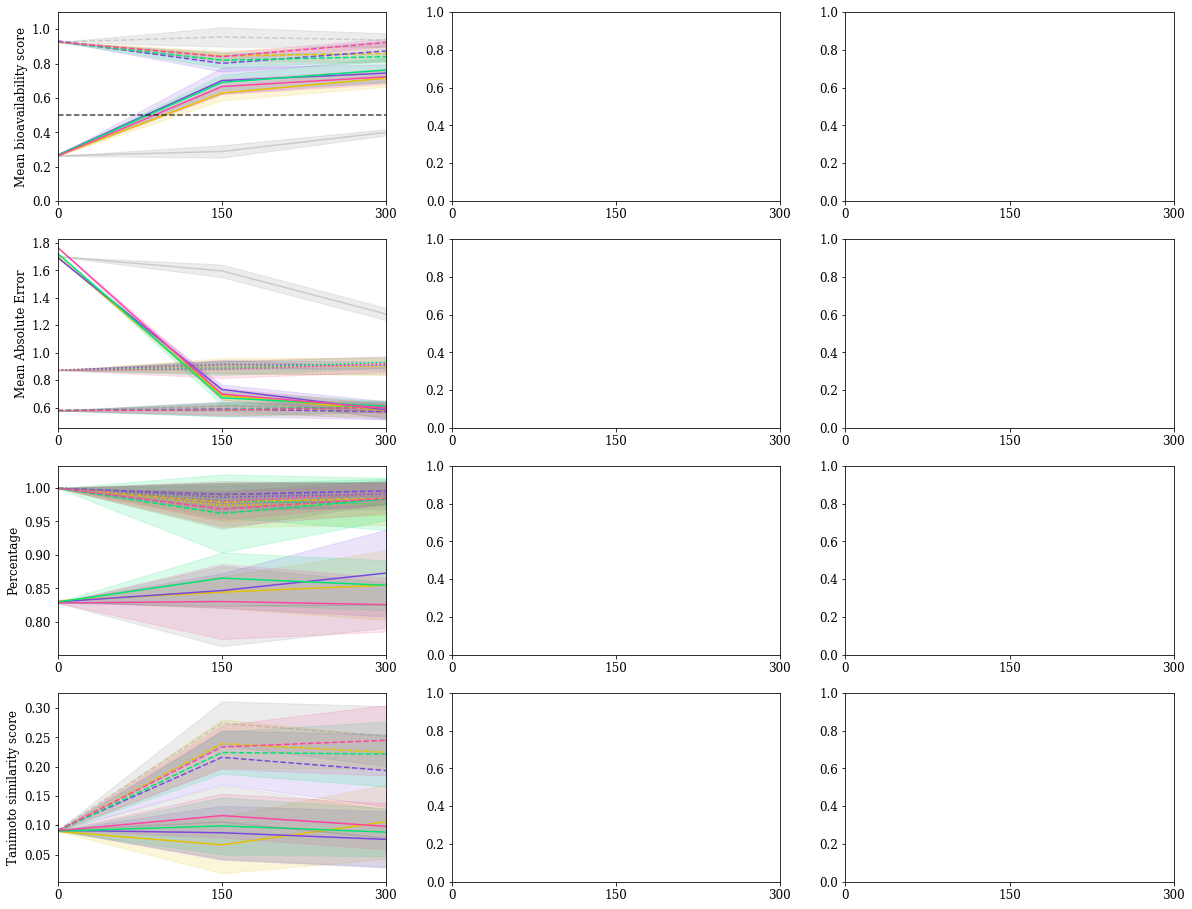

In [13]:
font = {'family': 'serif',  # You can use 'serif', 'sans-serif', 'monospace', etc.
        'weight': 'normal',  # You can use 'normal', 'bold', 'heavy', 'light', 'ultrabold', 'ultralight', etc.
        'size': 12}  # Font size in points

# Apply the font settings to Matplotlib's rcParams
matplotlib.rc('font', **font)

labels = ["No Active Learning"] + acquisition_method_names
colors = high_contrast_pastel_colors_hex
all_colors = ["gray"] + colors

# Create a figure with subplots
fig, axes = plt.subplots(4, 3, figsize=(20, 16))

# First Row: Curves
x = np.arange(1, 4)  # Sample data for x-axis

for i in range(len(acquisition_method_names)):
    col = colors[i]
    axes[0,0].plot(x, mean_oracle_scores_logp[0][i], color = col)
    axes[0,0].plot(x, mean_pred_scores_logp[0][i], color = col, linestyle="--")
    axes[0,0].fill_between(x, 
                     mean_oracle_scores_logp[2][i], #low error
                     mean_oracle_scores_logp[1][i], #high error
                         color = col, alpha = 0.15
                    )
    axes[0,0].fill_between(x, 
                     mean_pred_scores_logp[2][i],
                     mean_pred_scores_logp[1][i], 
                         color = col, alpha = 0.15
                    )
    
axes[0,0].plot(x, mean_oracle_scores_logp_base[0], color = "gray", alpha = 0.3)
axes[0,0].plot(x, mean_pred_scores_logp_base[0], color = "gray", linestyle="--", alpha = 0.3)
axes[0,0].fill_between(x, 
                         mean_oracle_scores_logp_base[2],
                         mean_oracle_scores_logp_base[1], 
                             color = "gray", alpha = 0.15
                        )
axes[0,0].fill_between(x, 
                         mean_pred_scores_logp_base[2],
                         mean_pred_scores_logp_base[1], 
                             color = "gray", alpha = 0.15
                        )


#axes[0,0].plot(x, mean_oracle_scores_logp_janosch[0], color = "yellow", alpha = 0.3)
#axes[0,0].plot(x, mean_pred_scores_logp_janosch[0], color = "yellow", linestyle="--", alpha = 0.3)
#axes[0,0].fill_between(x, 
#                         mean_oracle_scores_logp_janosch[2],
#                         mean_oracle_scores_logp_janosch[1], 
#                             color = "yellow", alpha = 0.15
#                        )
#axes[0,0].fill_between(x, 
#                         mean_pred_scores_logp_janosch[2],
#                         mean_pred_scores_logp_janosch[1], 
#                             color = "yellow", alpha = 0.15
#                        )

#axes[0,0].plot(x, mean_oracle_scores_logp_biggerTrainSet[0], color = "cyan", alpha = 0.3)
#axes[0,0].plot(x, mean_pred_scores_logp_biggerTrainSet[0], color = "cyan", linestyle="--", alpha = 0.3)
#axes[0,0].fill_between(x, 
#                         mean_oracle_scores_logp_biggerTrainSet[2],
#                         mean_oracle_scores_logp_biggerTrainSet[1], 
#                             color = "cyan", alpha = 0.15
#                        )
#axes[0,0].fill_between(x, 
#                         mean_pred_scores_logp_biggerTrainSet[2],
#                         mean_pred_scores_logp_biggerTrainSet[1], 
#                             color = "cyan", alpha = 0.15
#                        )

axes[0,0].set_ylim((0,1.1))
axes[0,0].axhline(y=0.5, linestyle="--", color="black", alpha=0.7)
axes[0,0].set_ylabel("Mean bioavailability score")

################################################

for i in range(len(acquisition_method_names)):
    col = colors[i]
    axes[1,0].plot(x, mae_wrt_current_logp[0][i], color = col)
    axes[1,0].plot(x, mae_wrt_d0_logp[0][i], color = col, linestyle="--")
    axes[1,0].plot(x, mae_wrt_chembl_logp[0][i], color = col, linestyle=":")
    axes[1,0].fill_between(x, 
                     mae_wrt_current_logp[2][i], #low error
                     mae_wrt_current_logp[1][i], #high error
                         color = col, alpha = 0.15
                    )
    axes[1,0].fill_between(x, 
                     mae_wrt_d0_logp[2][i],
                     mae_wrt_d0_logp[1][i], 
                         color = col, alpha = 0.15
                    )
    axes[1,0].fill_between(x, 
                     mae_wrt_chembl_logp[2][i],
                     mae_wrt_chembl_logp[1][i], 
                         color = col, alpha = 0.15
                    )
    
axes[1,0].plot(x, mae_wrt_current_logp_base[0], color = "gray", alpha = 0.3)
axes[1,0].plot(x, mae_wrt_d0_logp_base[0], color = "gray", linestyle="--", alpha = 0.3)
axes[1,0].plot(x, mae_wrt_chembl_logp_base[0], color = "gray", linestyle=":", alpha = 0.3)
axes[1,0].fill_between(x, 
                         mae_wrt_current_logp_base[2],
                         mae_wrt_current_logp_base[1], 
                             color = "gray", alpha = 0.15
                        )
axes[1,0].fill_between(x, 
                         mae_wrt_d0_logp_base[2],
                         mae_wrt_d0_logp_base[1], 
                             color = "gray", alpha = 0.15
                        )

axes[1,0].fill_between(x, 
                         mae_wrt_chembl_logp_base[2],
                         mae_wrt_chembl_logp_base[1], 
                             color = "gray", alpha = 0.15
                        )

axes[1,0].set_ylabel("Mean Absolute Error")

#################################

for i in range(len(acquisition_method_names)):
    col = colors[i]
    axes[2,0].plot(x, diversity_logp[0][i], color = col)
    axes[2,0].plot(x, uniqueness_logp[0][i], color = col, linestyle="--")
    axes[2,0].plot(x, validity_logp[0][i], color = col, linestyle=":")
    axes[2,0].fill_between(x, 
                     diversity_logp[2][i], #low error
                     diversity_logp[1][i], #high error
                         color = col, alpha = 0.15
                    )
    axes[2,0].fill_between(x, 
                     uniqueness_logp[2][i],
                     uniqueness_logp[1][i], 
                         color = col, alpha = 0.15
                    )
    axes[2,0].fill_between(x, 
                     validity_logp[2][i],
                     validity_logp[1][i], 
                         color = col, alpha = 0.15
                    )
    
axes[2,0].plot(x, diversity_logp_base[0], color = "gray", alpha = 0.3)
axes[2,0].plot(x, uniqueness_logp_base[0], color = "gray", linestyle="--", alpha = 0.3)
axes[2,0].plot(x, validity_logp_base[0], color = "gray", linestyle=":", alpha = 0.3)
axes[2,0].fill_between(x, 
                         diversity_logp_base[2],
                         diversity_logp_base[1], 
                             color = "gray", alpha = 0.15
                        )
axes[2,0].fill_between(x, 
                         uniqueness_logp_base[2],
                         uniqueness_logp_base[1], 
                             color = "gray", alpha = 0.15
                        )

axes[2,0].fill_between(x, 
                         validity_logp_base[2],
                         validity_logp_base[1], 
                             color = "gray", alpha = 0.15
                        )

axes[2,0].set_ylabel("Percentage")

#####################################

for i in range(len(acquisition_method_names)):
    col = colors[i]
    axes[3,0].plot(x, similarity_wrt_d0_logp[0][i], color = col)
    axes[3,0].plot(x, similarity_wrt_previous_logp[0][i], color = col, linestyle="--")
    axes[3,0].fill_between(x, 
                     similarity_wrt_d0_logp[2][i], #low error
                     similarity_wrt_d0_logp[1][i], #high error
                         color = col, alpha = 0.15
                    )
    axes[3,0].fill_between(x, 
                     similarity_wrt_previous_logp[2][i],
                     similarity_wrt_previous_logp[1][i], 
                         color = col, alpha = 0.15
                    )
    
axes[3,0].plot(x, similarity_wrt_d0_logp_base[0], color = "gray", alpha = 0.3)
axes[3,0].plot(x, similarity_wrt_previous_logp_base[0], color = "gray", linestyle="--", alpha = 0.3)
axes[3,0].fill_between(x, 
                         similarity_wrt_d0_logp_base[2],
                         similarity_wrt_d0_logp_base[1], 
                             color = "gray", alpha = 0.15
                        )
axes[3,0].fill_between(x, 
                         similarity_wrt_previous_logp_base[2],
                         similarity_wrt_previous_logp_base[1], 
                             color = "gray", alpha = 0.15
                        )

axes[3,0].set_ylabel("Tanimoto similarity score")

for i in range(4):
    for j in range(3):
        axes[i,j].set_xlim((1,3))
        axes[i,j].set_xticks(x)
        axes[i,j].set_xticklabels(np.arange(0, 450, 150))

In [ ]:
font = {'family': 'serif',  # You can use 'serif', 'sans-serif', 'monospace', etc.
        'weight': 'normal',  # You can use 'normal', 'bold', 'heavy', 'light', 'ultrabold', 'ultralight', etc.
        'size': 12}  # Font size in points

# Apply the font settings to Matplotlib's rcParams
matplotlib.rc('font', **font)

labels = ["No Active Learning"] + acquisition_method_names
colors = high_contrast_pastel_colors_hex
all_colors = ["gray"] + colors

# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

# First Row: Curves
x = np.arange(1, 4)  # Sample data for x-axis

for i in range(len(acquisition_method_names)):
    col = colors[i]
    axes[0,0].plot(x, Sy1[i][:-1], color = col)
    axes[0,0].fill_between(x, 
                     Sy1_errdown[i][:-1],
                     Sy1_errup[i][:-1], 
                         color = col, alpha = 0.15
                    )
    
axes[0,0].plot(x, Sy1_base[:-1], color = "gray")
axes[0,0].fill_between(x, 
                         Sy1_base_errdown[:-1],
                         Sy1_base_errup[:-1], 
                             color = "gray", alpha = 0.15
                        )
axes[0,0].set_ylim((0,1.01))
axes[0,0].set_xticks(x)
axes[0,0].axhline(y=0.5, linestyle="--", color="black", alpha=0.7)
axes[0,0].set_xticklabels(np.arange(0, 150, 50))
axes[0,0].set_title('Agent not pre-trained \n no similarity constraints')


for i in range(len(acquisition_method_names)):
    col = colors[i]
    axes[0,1].plot(x, Sy2[i][:-1], color = col)
    axes[0,1].fill_between(x, 
                     Sy2_errdown[i][:-1],
                     Sy2_errup[i][:-1], 
                         color = col, alpha = 0.15
                    )
    
axes[0,1].plot(x, Sy2_base[:-1], color = "gray")
axes[0,1].fill_between(x, 
                         Sy2_base_errdown[:-1],
                         Sy2_base_errup[:-1], 
                             color = "gray", alpha = 0.15
                        )
axes[0,1].set_ylim((0,1.01))
axes[0,1].set_xticks(x)
axes[0,1].axhline(y=0.5, linestyle="--", color="black", alpha=0.7)
axes[0,1].set_xticklabels(np.arange(0, 150, 50))
axes[0,1].set_title('Similarity to train set optimized')



for i in range(len(acquisition_method_names)):
    col = colors[i]
    axes[0,2].plot(x, Sy3[i][:-1], color = col)
    axes[0,2].fill_between(x, 
                     Sy3_errdown[i][:-1],
                     Sy3_errup[i][:-1], 
                         color = col, alpha = 0.15
                    )
    
axes[0,2].plot(x, Sy3_base[:-1], color = "gray")
axes[0,2].fill_between(x, 
                     Sy3_base_errdown[:-1],
                     Sy3_base_errup[:-1], 
                         color = "gray", alpha = 0.15
                    )
axes[0,2].set_ylim((0.5, 1.01))
axes[0,2].set_xticks(x)
#axes[0,2].axhline(y=0.5, linestyle="--", color="black", alpha=0.7)
axes[0,2].set_xticklabels(np.arange(0, 150, 50))
axes[0,2].set_title("Agent pre-trained")

# Second Row: Bar Plots

# Create an array of rounds for the x-axis
rounds = np.arange(1, len(acquisition_method_names))
num_methods = len(acquisition_method_names)

# Set the width of the bars
bar_width = 0.15

# Create bars for data2 and add error bars
axes[1,0].bar(
    rounds,
    Sy1_base[:-1],
    width=bar_width,
    label='No Active Learning',
    alpha=0.9,
    color="gray"
)
axes[1,0].errorbar(
    rounds,
    Sy1_base[:-1],
    yerr=[Sy1_base[:-1] - Sy1_base_errdown[:-1], Sy1_base_errup[:-1] - Sy1_base[:-1]],
    fmt='none',
    ecolor='black',
    elinewidth=1,
    capsize=5,
    capthick=1,
    barsabove=True,
    color="gray"
)

# Create bars for each method in data1 and add error bars
for i, (row, upper, lower) in enumerate(zip(Sy1, Sy1_errup, Sy1_errdown)):
    axes[1,0].bar(
        rounds + (i + 1) * bar_width,
        row[:-1],
        width=bar_width,
        label=f'Method {i+1}',
        alpha=0.9,
        color=colors[i]
    )
    axes[1,0].errorbar(
        rounds + (i + 1) * bar_width,
        row[:-1],
        yerr=[row[:-1] - lower[:-1], upper[:-1] - row[:-1]],
        fmt='none',
        ecolor='black',
        elinewidth=1,
        capsize=5,
        capthick=1,
        barsabove=True,
        color=colors[i]
    )

# Set labels and title
axes[1,0].set_xticks(rounds + bar_width * ((num_methods - 1) / 2))
axes[1,0].axhline(y=0.5, linestyle="--", color="black", alpha=0.7)
axes[1,0].set_xticklabels(np.arange(0, 150, 50))
axes[1,0].set_ylim((0,1.01))


# Create bars for data2 and add error bars
axes[1,1].bar(
    rounds,
    Sy2_base[:-1],
    width=bar_width,
    label='No Active Learning',
    alpha=0.9,
    color="gray"
)
axes[1,1].errorbar(
    rounds,
    Sy2_base[:-1],
    yerr=[Sy2_base[:-1] - Sy2_base_errdown[:-1], Sy2_base_errup[:-1] - Sy2_base[:-1]],
    fmt='none',
    ecolor='black',
    elinewidth=1,
    capsize=5,
    capthick=1,
    barsabove=True,
    color="gray"
)

# Create bars for each method in data1 and add error bars
for i, (row, upper, lower) in enumerate(zip(Sy2, Sy2_errup, Sy2_errdown)):
    axes[1,1].bar(
        rounds + (i + 1) * bar_width,
        row[:-1],
        width=bar_width,
        label=f'Method {i+1}',
        alpha=0.9,
        color = colors[i]
    )
    axes[1,1].errorbar(
        rounds + (i + 1) * bar_width,
        row[:-1],
        yerr=[row[:-1] - lower[:-1], upper[:-1] - row[:-1]],
        fmt='none',
        ecolor='black',
        elinewidth=1,
        capsize=5,
        capthick=1,
        barsabove=True,
        color = colors[i]
    )

# Set labels and title
axes[1,1].set_xticks(rounds + bar_width * ((num_methods - 1) / 2))
axes[1,1].axhline(y=0.5, linestyle="--", color="black", alpha=0.7)
axes[1,1].set_xticklabels(np.arange(0, 150, 50))



###
# Create bars for data2 and add error bars
axes[1,2].bar(
    rounds,
    Sy3_base[:-1],
    width=bar_width,
    label='No Active Learning',
    alpha=0.9,
    color="gray"
)
axes[1,2].errorbar(
    rounds,
    Sy3_base[:-1],
    yerr=[Sy3_base[:-1] - Sy3_base_errdown[:-1], Sy3_base_errup[:-1] - Sy3_base[:-1]],
    fmt='none',
    ecolor='black',
    elinewidth=1,
    capsize=5,
    capthick=1,
    barsabove=True,
    color="gray"
)

# Create bars for each method in data1 and add error bars
for i, (row, upper, lower) in enumerate(zip(Sy3, Sy3_errup, Sy3_errdown)):
    axes[1,2].bar(
        rounds + (i + 1) * bar_width,
        row[:-1],
        width=bar_width,
        label=f'Method {i+1}',
        alpha=0.9,
        color=colors[i]
    )
    axes[1,2].errorbar(
        rounds + (i + 1) * bar_width,
        row[:-1],
        yerr=[row[:-1] - lower[:-1], upper[:-1] - row[:-1]],
        fmt='none',
        ecolor='black',
        elinewidth=1,
        capsize=5,
        capthick=1,
        barsabove=True,
        color=colors[i]
    )

# Set labels and title
axes[1,2].set_ylim((0.5, 1.02))
axes[1,2].set_xticks(rounds + bar_width * ((num_methods - 1) / 2))
#axes[1,2].axhline(y=0.5, linestyle="--", color="black", alpha=0.7)
axes[1,2].set_xticklabels(np.arange(0, 150, 50))

legend_patches = [Rectangle((0, 0), 1, 1, color=color, label=label) for label, color in zip(labels, all_colors)]
legend_labels = [patch.get_label() for patch in legend_patches]

# Add common y-label on the left
fig.text(0.02, 0.5, 'Mean Oracle Score', va='center', rotation='vertical')

# Add common x-label at the bottom
fig.text(0.53, 0.02, 'Number of queries to expert', ha='center')

# Create a custom legend box
legend_patches = [Rectangle((0, 0), 1, 1, color=color, label=label) for label, color in zip(labels, all_colors)]
legend_labels = [patch.get_label() for patch in legend_patches]

# Calculate the position for the legend on top of the figure
legend_x = 0.5  # X-coordinate for the legend
legend_y = 1.05  # Y-coordinate for the legend (adjust as needed)

# Add the legend patches to a common legend box on top of the figure
#fig.legend(handles=legend_patches, labels=legend_labels, loc="upper center", bbox_to_anchor=(legend_x, legend_y))

plt.subplots_adjust(left=0.07, right=1., bottom=0.09, top=1., wspace=0.15, hspace=0.15)


# Show the plot
plt.show()

In [ ]:
font = {'family': 'serif',  # You can use 'serif', 'sans-serif', 'monospace', etc.
        'weight': 'normal',  # You can use 'normal', 'bold', 'heavy', 'light', 'ultrabold', 'ultralight', etc.
        'size': 12}  # Font size in points

# Apply the font settings to Matplotlib's rcParams
matplotlib.rc('font', **font)

labels = ["No Active Learning"] + acquisition_method_names
colors = high_contrast_pastel_colors_hex
all_colors = ["gray"] + colors

# Create a figure with subplots
fig, axes = plt.subplots(figsize=(8, 6))

# First Row: Curves
x = np.arange(1, 4)  # Sample data for x-axis

for i in range(len(Sy1_logp)):
    col = colors[i]
    axes.plot(x, Sy1_logp[i][:-1], color = col)
    axes.plot(x, Sy1_logp_pred[i][:-1], color = col, linestyle="--")
    axes.fill_between(x, 
                     Sy1_logp_errdown[i][:-1],
                     Sy1_logp_errup[i][:-1], 
                         color = col, alpha = 0.15
                    )
    axes.fill_between(x, 
                     Sy1_logp_pred_errdown[i][:-1],
                     Sy1_logp_pred_errup[i][:-1], 
                         color = col, alpha = 0.15
                    )
    
axes.plot(x, Sy1_logp_base[:-1], color = "gray", alpha = 0.3)
axes.plot(x, Sy1_logp_pred_base[:-1], color = "gray", linestyle="--", alpha = 0.3)
axes.fill_between(x, 
                         Sy1_logp_base_errdown[:-1],
                         Sy1_logp_base_errup[:-1], 
                             color = "gray", alpha = 0.15
                        )
axes.fill_between(x, 
                         Sy1_logp_pred_base_errdown[:-1],
                         Sy1_logp_pred_base_errup[:-1], 
                             color = "gray", alpha = 0.15
                        )


axes.plot(x, Sy1_logp_janosch[:-1], color = "yellow", alpha = 0.3)
axes.plot(x, Sy1_logp_pred_janosch[:-1], color = "yellow", linestyle="--", alpha = 0.3)
axes.fill_between(x, 
                         Sy1_logp_janosch_errdown[:-1],
                         Sy1_logp_janosch_errup[:-1], 
                             color = "yellow", alpha = 0.15
                        )
axes.fill_between(x, 
                         Sy1_logp_pred_janosch_errdown[:-1],
                         Sy1_logp_pred_janosch_errup[:-1], 
                             color = "yellow", alpha = 0.15
                        )

axes.plot(x, Sy1_logp_biggerTrain[:-1], color = "cyan", alpha = 0.3)
axes.plot(x, Sy1_logp_pred_biggerTrain[:-1], color = "cyan", linestyle="--", alpha = 0.3)
axes.fill_between(x, 
                         Sy1_logp_biggerTrain_errdown[:-1],
                         Sy1_logp_biggerTrain_errup[:-1], 
                             color = "cyan", alpha = 0.15
                        )
axes.fill_between(x, 
                         Sy1_logp_pred_biggerTrain_errdown[:-1],
                         Sy1_logp_pred_biggerTrain_errup[:-1], 
                             color = "cyan", alpha = 0.15
                        )

axes.set_ylim((0,1.1))
axes.set_xlim((1,3))
axes.axhline(y=0.5, linestyle="--", color="black", alpha=0.7)
axes.set_xticks(x)
axes.set_xticklabels(np.arange(0, 450, 150))
axes.set_title('Simulated expert (noise-free)')
axes.set_xlabel("Number of queries to expert")
axes.set_ylabel("Mean Bioavailability Score")

In [ ]:
font = {'family': 'serif',  # You can use 'serif', 'sans-serif', 'monospace', etc.
        'weight': 'normal',  # You can use 'normal', 'bold', 'heavy', 'light', 'ultrabold', 'ultralight', etc.
        'size': 12}  # Font size in points

# Apply the font settings to Matplotlib's rcParams
matplotlib.rc('font', **font)

labels = ["No Active Learning"] + acquisition_method_names
colors = high_contrast_pastel_colors_hex
all_colors = ["gray"] + colors

# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

# First Row: Curves
x = np.arange(1, 4)  # Sample data for x-axis

for i in range(num_methods):
    col = colors[i]
    axes[0,0].plot(x, Sy1_logp[i][:-1], color = col)
    axes[0,0].fill_between(x, 
                     Sy1_logp_errdown[i][:-1],
                     Sy1_logp_errup[i][:-1], 
                         color = col, alpha = 0.15
                    )
    
axes[0,0].plot(x, Sy1_logp_base[:-1], color = "gray")
axes[0,0].fill_between(x, 
                         Sy1_logp_base_errdown[:-1],
                         Sy1_logp_base_errup[:-1], 
                             color = "gray", alpha = 0.15
                        )
axes[0,0].axhline(y=0.5, linestyle="--", color="black", alpha=0.7)
axes[0,0].set_ylim((0, 1.01))
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(np.arange(0, 350, 150))
axes[0,0].set_title('Agent not pre-trained \n no similarity constraints')


for i in range(num_methods):
    col = colors[i]
    axes[0,1].plot(x, Sy2_logp[i][:-1], color = col)
    axes[0,1].fill_between(x, 
                     Sy2_errdown_logp[i][:-1],
                     Sy2_errup_logp[i][:-1], 
                         color = col, alpha = 0.15
                    )
    
axes[0,1].plot(x, Sy2_base_logp[:-1], color = "gray")
axes[0,1].fill_between(x, 
                         Sy2_base_errdown_logp[:-1],
                         Sy2_base_errup_logp[:-1], 
                             color = "gray", alpha = 0.15
                        )
axes[0,1].axhline(y=0.5, linestyle="--", color="black", alpha=0.7)
axes[0,1].set_ylim((0,1.01))
axes[0,1].set_xticks(x)
axes[0,1].set_xticklabels(np.arange(0, 350, 150))
axes[0,1].set_title('Similarity to train set optimized')



for i in range(num_methods):
    col = colors[i]
    axes[0,2].plot(x, Sy3_logp[i][:-1], color = col)
    axes[0,2].fill_between(x, 
                     Sy3_errdown_logp[i][:-1],
                     Sy3_errup_logp[i][:-1], 
                         color = col, alpha = 0.15
                    )
    
axes[0,2].plot(x, Sy3_base_logp[:-1], color = "gray")
axes[0,2].fill_between(x, 
                     Sy3_base_errdown_logp[:-1],
                     Sy3_base_errup_logp[:-1], 
                         color = "gray", alpha = 0.15
                    )
axes[0,2].set_ylim((0., 1.01))
axes[0,2].set_xticks(x)
axes[0,2].set_xticklabels(np.arange(0, 350, 150))
axes[0,2].set_title("Agent pre-trained")

# Second Row: Bar Plots

# Create an array of rounds for the x-axis
rounds = np.arange(1, 4)
num_methods = 4

# Set the width of the bars
bar_width = 0.15

# Create bars for data2 and add error bars
axes[1,0].bar(
    rounds,
    Sy1_logp_base[:-1],
    width=bar_width,
    label='No Active Learning',
    alpha=0.9,
    color="gray"
)
axes[1,0].errorbar(
    rounds,
    Sy1_logp_base[:-1],
    yerr=[Sy1_logp_base[:-1] - Sy1_logp_base_errdown[:-1], Sy1_logp_base_errup[:-1] - Sy1_logp_base[:-1]],
    fmt='none',
    ecolor='black',
    elinewidth=1,
    capsize=5,
    capthick=1,
    barsabove=True,
    color="gray"
)

# Create bars for each method in data1 and add error bars
for i, (row, upper, lower) in enumerate(zip(Sy1_logp, Sy1_logp_errup, Sy1_logp_errdown)):
    axes[1,0].bar(
        rounds + (i + 1) * bar_width,
        row[:-1],
        width=bar_width,
        label=f'Method {i+1}',
        alpha=0.9,
        color=colors[i]
    )
    axes[1,0].errorbar(
        rounds + (i + 1) * bar_width,
        row[:-1],
        yerr=[row[:-1] - lower[:-1], upper[:-1] - row[:-1]],
        fmt='none',
        ecolor='black',
        elinewidth=1,
        capsize=5,
        capthick=1,
        barsabove=True,
        color=colors[i]
    )

# Set labels and title
axes[1,0].axhline(y=0.5, linestyle="--", color="black", alpha=0.7)
axes[1,0].set_xticks(rounds + bar_width * ((num_methods - 1) / 2))
axes[1,0].set_xticklabels(np.arange(0, 350, 150))
axes[1,0].set_ylim((0,1.01))


# Create bars for data2 and add error bars
axes[1,1].bar(
    rounds,
    Sy2_base_logp[:-1],
    width=bar_width,
    label='No Active Learning',
    alpha=0.9,
    color="gray"
)
axes[1,1].errorbar(
    rounds,
    Sy2_base_logp[:-1],
    yerr=[Sy2_base_logp[:-1] - Sy2_base_errdown_logp[:-1], Sy2_base_errup_logp[:-1] - Sy2_base_logp[:-1]],
    fmt='none',
    ecolor='black',
    elinewidth=1,
    capsize=5,
    capthick=1,
    barsabove=True,
    color="gray"
)

# Create bars for each method in data1 and add error bars
for i, (row, upper, lower) in enumerate(zip(Sy2_logp, Sy2_errup_logp, Sy2_errdown_logp)):
    axes[1,1].bar(
        rounds + (i + 1) * bar_width,
        row[:-1],
        width=bar_width,
        label=f'Method {i+1}',
        alpha=0.9,
        color = colors[i]
    )
    axes[1,1].errorbar(
        rounds + (i + 1) * bar_width,
        row[:-1],
        yerr=[row[:-1] - lower[:-1], upper[:-1] - row[:-1]],
        fmt='none',
        ecolor='black',
        elinewidth=1,
        capsize=5,
        capthick=1,
        barsabove=True,
        color = colors[i]
    )

# Set labels and title
axes[1,1].set_ylim((0., 1.01))
axes[1,1].axhline(y=0.5, linestyle="--", color="black", alpha=0.7)
axes[1,1].set_xticks(rounds + bar_width * ((num_methods - 1) / 2))
axes[1,1].set_xticklabels(np.arange(0, 350, 150))



###
# Create bars for data2 and add error bars
axes[1,2].bar(
    rounds,
    Sy3_base_logp[:-1],
    width=bar_width,
    label='No Active Learning',
    alpha=0.9,
    color="gray"
)
axes[1,2].errorbar(
    rounds,
    Sy3_base_logp[:-1],
    yerr=[Sy3_base_logp[:-1] - Sy3_base_errdown_logp[:-1], Sy3_base_errup_logp[:-1] - Sy3_base_logp[:-1]],
    fmt='none',
    ecolor='black',
    elinewidth=1,
    capsize=5,
    capthick=1,
    barsabove=True,
    color="gray"
)

# Create bars for each method in data1 and add error bars
for i, (row, upper, lower) in enumerate(zip(Sy3_logp, Sy3_errup_logp, Sy3_errdown_logp)):
    axes[1,2].bar(
        rounds + (i + 1) * bar_width,
        row[:-1],
        width=bar_width,
        label=f'Method {i+1}',
        alpha=0.9,
        color=colors[i]
    )
    axes[1,2].errorbar(
        rounds + (i + 1) * bar_width,
        row[:-1],
        yerr=[row[:-1] - lower[:-1], upper[:-1] - row[:-1]],
        fmt='none',
        ecolor='black',
        elinewidth=1,
        capsize=5,
        capthick=1,
        barsabove=True,
        color=colors[i]
    )

# Set labels and title
axes[1,2].set_ylim((0., 1.01))
axes[1,2].set_xticks(rounds + bar_width * ((num_methods - 1) / 2))
axes[1,2].set_xticklabels(np.arange(0, 350, 150))

legend_patches = [Rectangle((0, 0), 1, 1, color=color, label=label) for label, color in zip(labels, all_colors)]
legend_labels = [patch.get_label() for patch in legend_patches]

# Add common y-label on the left
fig.text(0.02, 0.55, 'Mean Oracle Score', va='center', rotation='vertical')

# Add common x-label at the bottom
fig.text(0.53, 0.02, 'Number of queries to expert', ha='center')

# Create a custom legend box
legend_patches = [Rectangle((0, 0), 1, 1, color=color, label=label) for label, color in zip(labels, all_colors)]
legend_labels = [patch.get_label() for patch in legend_patches]

# Calculate the position for the legend on top of the figure
legend_x = 0.5  # X-coordinate for the legend
legend_y = 1.05  # Y-coordinate for the legend (adjust as needed)

# Add the legend patches to a common legend box on top of the figure
#fig.legend(handles=legend_patches, labels=legend_labels, loc="upper center", bbox_to_anchor=(legend_x, legend_y))

plt.subplots_adjust(left=0.07, right=1., bottom=0.09, top=1., wspace=0.15, hspace=0.15)


# Show the plot
plt.show()

In [ ]:
# increasing noises

font = {'family': 'serif',  # You can use 'serif', 'sans-serif', 'monospace', etc.
        'weight': 'normal',  # You can use 'normal', 'bold', 'heavy', 'light', 'ultrabold', 'ultralight', etc.
        'size': 12}  # Font size in points

# Apply the font settings to Matplotlib's rcParams
matplotlib.rc('font', **font)

labels = ["No Active Learning"] + acquisition_method_names
colors = high_contrast_pastel_colors_hex
all_colors = ["gray"] + colors

# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

# First Row: Curves
x = np.arange(1, 4)  # Sample data for x-axis

for i in range(len(Sy1_logp)):
    col = colors[i]
    axes[0,0].plot(x, Sy1_logp[i][:-1], color = col)
    axes[0,0].plot(x, Sy1_logp_pred[i][:-1], color = col, linestyle="--")
    axes[0,0].fill_between(x, 
                     Sy1_logp_errdown[i][:-1],
                     Sy1_logp_errup[i][:-1], 
                         color = col, alpha = 0.15
                    )
    axes[0,0].fill_between(x, 
                     Sy1_logp_pred_errdown[i][:-1],
                     Sy1_logp_pred_errup[i][:-1], 
                         color = col, alpha = 0.15
                    )
    
axes[0,0].plot(x, Sy1_logp_base[:-1], color = "gray", alpha = 0.3)
axes[0,0].plot(x, Sy1_logp_pred_base[:-1], color = "gray", linestyle="--", alpha = 0.3)
axes[0,0].fill_between(x, 
                         Sy1_logp_base_errdown[:-1],
                         Sy1_logp_base_errup[:-1], 
                             color = "gray", alpha = 0.15
                        )
axes[0,0].fill_between(x, 
                         Sy1_logp_pred_base_errdown[:-1],
                         Sy1_logp_pred_base_errup[:-1], 
                             color = "gray", alpha = 0.15
                        )
axes[0,0].set_ylim((0,1.1))
axes[0,0].set_xlim((1,3))
axes[0,0].axhline(y=0.5, linestyle="--", color="black", alpha=0.7)
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(np.arange(0, 350, 150))
axes[0,0].set_title('Simulated expert (noise-free)')


for i in range(len(Sy1_05_logp)):
    col = colors[i]
    axes[0,1].plot(x, Sy1_05_logp[i][:-1], color = col)
    axes[0,1].plot(x, Sy1_05_logp_pred[i][:-1], color = col, linestyle="--")
    axes[0,1].fill_between(x, 
                     Sy1_05_logp_errdown[i][:-1],
                     Sy1_05_logp_errup[i][:-1], 
                         color = col, alpha = 0.15
                    )
    axes[0,1].fill_between(x, 
                     Sy1_05_logp_pred_errdown[i][:-1],
                     Sy1_05_logp_pred_errup[i][:-1], 
                         color = col, alpha = 0.15
                    )

    
axes[0,1].plot(x, Sy1_05_logp_base[:-1], color = "gray", alpha = 0.3)
axes[0,1].plot(x, Sy1_05_logp_pred_base[:-1], color = "gray", linestyle="--", alpha = 0.3)
axes[0,1].fill_between(x, 
                         Sy1_05_logp_base_errdown[:-1],
                         Sy1_05_logp_base_errup[:-1], 
                             color = "gray", alpha = 0.15
                        )
axes[0,1].fill_between(x, 
                         Sy1_05_logp_pred_base_errdown[:-1],
                         Sy1_05_logp_pred_base_errup[:-1], 
                             color = "gray", alpha = 0.15
                        )


axes[0,1].set_ylim((0,1.1))
axes[0,1].set_xlim((1,3))
axes[0,1].axhline(y=0.5, linestyle="--", color="black", alpha=0.7)
axes[0,1].set_xticks(x)
axes[0,1].set_xticklabels(np.arange(0, 350, 150))
axes[0,1].set_title('Simulated expert (moderate noise)')


for i in range(len(Sy1_1_logp)):
    col = colors[i]
    axes[0,2].plot(x, Sy1_1_logp[i][:-1], color = col)
    axes[0,2].plot(x, Sy1_1_logp_pred[i][:-1], color = col, linestyle="--")
    axes[0,2].fill_between(x, 
                     Sy1_1_logp_errdown[i][:-1],
                     Sy1_1_logp_errup[i][:-1], 
                         color = col, alpha = 0.15
                    )
    axes[0,2].fill_between(x, 
                     Sy1_1_logp_pred_errdown[i][:-1],
                     Sy1_1_logp_pred_errup[i][:-1], 
                         color = col, alpha = 0.15
                    )
    
axes[0,2].plot(x, Sy1_1_logp_base[:-1], color = "gray", alpha = 0.3)
axes[0,2].plot(x, Sy1_1_logp_pred_base[:-1], color = "gray", linestyle="--", alpha = 0.3)
axes[0,2].fill_between(x, 
                         Sy1_1_logp_base_errdown[:-1],
                         Sy1_1_logp_base_errup[:-1], 
                             color = "gray", alpha = 0.15
                        )
axes[0,2].fill_between(x, 
                         Sy1_1_logp_pred_base_errdown[:-1],
                         Sy1_1_logp_pred_base_errup[:-1], 
                             color = "gray", alpha = 0.15
                        )
axes[0,2].set_ylim((0,1.1))
axes[0,2].set_xlim((1,3))
axes[0,2].axhline(y=0.5, linestyle="--", color="black", alpha=0.7)
axes[0,2].set_xticks(x)
axes[0,2].set_xticklabels(np.arange(0, 350, 150))
axes[0,2].set_title('Simulated expert (high noise)')


for i in range(len(Sy1)):
    col = colors[i]
    axes[1,0].plot(x, Sy1[i][:-1], color = col)
    axes[1,0].plot(x, Sy1_pred[i][:-1], color = col, linestyle = "--")
    axes[1,0].fill_between(x, 
                     Sy1_errdown[i][:-1],
                     Sy1_errup[i][:-1], 
                         color = col, alpha = 0.15
                    )
    axes[1,0].fill_between(x, 
                     Sy1_pred_errdown[i][:-1],
                     Sy1_pred_errup[i][:-1], 
                         color = col, alpha = 0.15
                    )
    
axes[1,0].plot(x, Sy1_base[:-1], color = "gray", alpha = 0.3)
axes[1,0].plot(x, Sy1_pred_base[:-1], color = "gray", linestyle = "--", alpha = 0.3)
axes[1,0].fill_between(x, 
                         Sy1_base_errdown[:-1],
                         Sy1_base_errup[:-1], 
                             color = "gray", alpha = 0.15
                        )
axes[1,0].fill_between(x, 
                         Sy1_pred_base_errdown[:-1],
                         Sy1_pred_base_errup[:-1], 
                             color = "gray", alpha = 0.15
                        )
axes[1,0].set_ylim((0,1.1))
axes[1,0].set_xlim((1,3))
axes[1,0].axhline(y=0.5, linestyle="--", color="black", alpha=0.7)
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(np.arange(0, 150, 50))


for i in range(len(Sy1_015)):
    col = colors[i]
    axes[1,1].plot(x, Sy1_015[i][:-1], color = col)
    axes[1,1].plot(x, Sy1_015_pred[i][:-1], color = col, linestyle="--")
    axes[1,1].fill_between(x, 
                     Sy1_015_errdown[i][:-1],
                     Sy1_015_errup[i][:-1], 
                         color = col, alpha = 0.15
                    )
    axes[1,1].fill_between(x, 
                     Sy1_015_pred_errdown[i][:-1],
                     Sy1_015_pred_errup[i][:-1], 
                         color = col, alpha = 0.15
                    )
    
axes[1,1].plot(x, Sy1_015_base[:-1], color = "gray", alpha = 0.3)
axes[1,1].plot(x, Sy1_015_pred_base[:-1], color = "gray", linestyle="--", alpha = 0.3)
axes[1,1].fill_between(x, 
                         Sy1_015_base_errdown[:-1],
                         Sy1_015_base_errup[:-1], 
                             color = "gray", alpha = 0.15
                        )
axes[1,1].fill_between(x, 
                         Sy1_pred_base_errdown[:-1],
                         Sy1_pred_base_errup[:-1], 
                             color = "gray", alpha = 0.15
                        )
axes[1,1].set_ylim((0,1.1))
axes[1,1].set_xlim((1,3))
axes[1,1].axhline(y=0.5, linestyle="--", color="black", alpha=0.7)
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(np.arange(0, 150, 50))


for i in range(len(Sy1_03)):
    col = colors[i]
    axes[1,2].plot(x, Sy1_03[i][:-1], color = col)
    axes[1,2].plot(x, Sy1_03_pred[i][:-1], color = col, linestyle="--")
    axes[1,2].fill_between(x, 
                     Sy1_03_errdown[i][:-1],
                     Sy1_03_errup[i][:-1], 
                         color = col, alpha = 0.15
                    )
    axes[1,2].fill_between(x, 
                     Sy1_03_pred_errdown[i][:-1],
                     Sy1_03_pred_errup[i][:-1], 
                         color = col, alpha = 0.15
                    )
    
axes[1,2].plot(x, Sy1_03_base[:-1], color = "gray", alpha = 0.3)
axes[1,2].plot(x, Sy1_03_pred_base[:-1], color = "gray", alpha = 0.3)
axes[1,2].fill_between(x, 
                         Sy1_03_base_errdown[:-1],
                         Sy1_03_base_errup[:-1], 
                             color = "gray", alpha = 0.15
                        )
axes[1,2].fill_between(x, 
                         Sy1_03_pred_base_errdown[:-1],
                         Sy1_03_pred_base_errup[:-1], 
                             color = "gray", alpha = 0.15
                        )

axes[1,2].set_ylim((0,1.1))
axes[1,2].set_xlim((1,3))
axes[1,2].axhline(y=0.5, linestyle="--", color="black", alpha=0.7)
axes[1,2].set_xticks(x)
axes[1,2].set_xticklabels(np.arange(0, 150, 50))


legend_patches = [Rectangle((0, 0), 1, 1, color=color, label=label) for label, color in zip(labels, all_colors)]
legend_labels = [patch.get_label() for patch in legend_patches]

fig.text(0.02, 0.28, 'Mean DRD2 Bioactivity Score', va='center', rotation='vertical')
fig.text(0.02, 0.8, 'Mean Bioavailability Score', va='center', rotation='vertical')

# Add common y-label on the left
#fig.text(-0.01, 0.54, 'Mean Oracle Score', va='center', rotation='vertical')

# Add common x-label at the bottom
fig.text(0.53, 0.013, 'Number of queries to expert', ha='center')

# Create a custom legend box
legend_patches = [Rectangle((0, 0), 1, 1, color=color, label=label) for label, color in zip(labels, all_colors)]
legend_labels = [patch.get_label() for patch in legend_patches]

# Calculate the position for the legend on top of the figure
legend_x = 0.5  # X-coordinate for the legend
legend_y = 1.05  # Y-coordinate for the legend (adjust as needed)

# Add the legend patches to a common legend box on top of the figure
#fig.legend(handles=legend_patches, labels=legend_labels, loc="upper center", bbox_to_anchor=(legend_x, legend_y))

plt.subplots_adjust(left=0.07, right=1., bottom=0.09, top=1., wspace=0.15, hspace=0.3)


# Show the plot
plt.show()